## Load Seismic Velocity Model Without Elevation Reference, coordinates in km 
Reference: 
DOI
10.15121/1989942

https://gdr.openei.org/submissions/1496


## 📘 Summary of the Notebook

- **Load Seismic Velocity Model**  
  Reads a whitespace‑delimited file containing Easting, Northing, elevation (`z[m]`) and velocity values (`Vp[km/s]` or `Vs[km/s]`) into a pandas DataFrame.

- **Filter by Elevation**  
  Defines `filter_and_save_vp_data` to select the points closest to specified reference elevations (e.g. 1500 m, 1000 m, …) within a tolerance, remove duplicate coordinates, save each slice as CSV and expose them as global DataFrames.

- **Interpolation to Raster**  
  Implements `interpolate_and_save_raster` which grids the velocity data on a regular mesh (e.g. via kriging), writes out a GeoTIFF raster and (optionally) a variogram plot for quality control.

- **2D Subplot Visualization**  
  Uses `plot_vp_subplots` to create a multi‑panel 2D scatter map of velocity at each elevation slice, with a shared color bar, customizable fonts, spacing and grid transparency.

- **3D Visualization Utility**  
  Provides a generic `visualize` function to render the 3D point‑cloud of velocity data (or well trajectories) colored by a property, either via Matplotlib’s 3D axes or an interactive PyVista scene—also supports overlaying a background image plane at a chosen depth.

## 🎯 Objective

Automate the end‑to‑end workflow for preprocessing, elevation‑based slicing, spatial gridding and both 2D/3D visualization of a seismic velocity model (and associated well trajectories) to streamline geophysical interpretation and analysis.  

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv

# Caminho do arquivo
file_path = "/home/marcus/Documentos/qualificacao_mestrado/dados_forge/Utah FORGE - Desenvolvimento de um modelo de velocidade sísmica de reservatório e estudo de resolução sísmica/Seismic_Velocity_Model_FORGE_Site"

# Carregar o arquivo
# Se os dados forem delimitados por espaço, usar delim_whitespace=True
# Caso contrário, ajustar o delimitador (ex: ',' para CSV)
try:
    df = pd.read_csv(file_path, delim_whitespace=True)
    print("Dados carregados com sucesso!")
    print(df.head())  # Mostrar as primeiras linhas para verificação
except Exception as e:
    print(f"Erro ao carregar o arquivo: {e}")


Dados carregados com sucesso!
   Easting[km]  Northing[km]  x[km]  y[km]  z[km]  Vp[km/s]  Vs[km/s]  Vp/Vs
0   332.800507   4260.690918  0.000    0.0    0.0       1.0     0.577  1.733
1   332.925507   4260.690918  0.125    0.0    0.0       1.0     0.577  1.733
2   333.050507   4260.690918  0.250    0.0    0.0       1.0     0.577  1.733
3   333.175507   4260.690918  0.375    0.0    0.0       1.0     0.577  1.733
4   333.300507   4260.690918  0.500    0.0    0.0       1.0     0.577  1.733


In [3]:
df.describe()

Easting[km]   Northing[km]          x[km]          y[km]  \
count  109265.000000  109265.000000  109265.000000  109265.000000   
mean      335.300507    4263.190918       2.500000       2.500000   
std         1.479027       1.479027       1.479027       1.479027   
min       332.800507    4260.690918       0.000000       0.000000   
25%       334.050507    4261.940918       1.250000       1.250000   
50%       335.300507    4263.190918       2.500000       2.500000   
75%       336.550507    4264.440918       3.750000       3.750000   
max       337.800507    4265.690918       5.000000       5.000000   

               z[km]       Vp[km/s]       Vs[km/s]          Vp/Vs  
count  109265.000000  109265.000000  109265.000000  109265.000000  
mean        4.000000       5.373735       3.128463       1.737091  
std         2.345219       1.169103       0.729512       0.120214  
min         0.000000       1.000000       0.431000       1.683000  
25%         2.000000       5.820000       3.409000       1.707000  
50%         4.000000       5.820000       3.409000       1.707000  
75%         6.000000       5.820000       3.409000       1.707000  
max         8.000000       6.184000       3.446000       2.382000

In [4]:
# Multiplicar os valores de Easting[km] e Northing[km] por 1000
df['Easting[km]'] = df['Easting[km]'] * 1000
df['Northing[km]'] = df['Northing[km]'] * 1000
df['x[km]'] = df['x[km]'] * 1000
df['y[km]'] = df['y[km]'] * 1000
df['z[km]'] = df['z[km]'] * 1000

# Renomear as colunas para Easting[m] e Northing[m]
df.rename(columns={'Easting[km]': 'Easting[m]', 'Northing[km]': 'Northing[m]', 'x[km]': 'x[m]', 'y[km]': 'y[m]', 'z[km]': 'z[m]'}, inplace=True)

# Exibir o DataFrame atualizado
print("DataFrame atualizado:")
print(df.head())


DataFrame atualizado:
   Easting[m]  Northing[m]   x[m]  y[m]  z[m]  Vp[km/s]  Vs[km/s]  Vp/Vs
0  332800.507  4260690.918    0.0   0.0   0.0       1.0     0.577  1.733
1  332925.507  4260690.918  125.0   0.0   0.0       1.0     0.577  1.733
2  333050.507  4260690.918  250.0   0.0   0.0       1.0     0.577  1.733
3  333175.507  4260690.918  375.0   0.0   0.0       1.0     0.577  1.733
4  333300.507  4260690.918  500.0   0.0   0.0       1.0     0.577  1.733


In [5]:
print(df)

        Easting[m]  Northing[m]    x[m]    y[m]    z[m]  Vp[km/s]  Vs[km/s]  \
0       332800.507  4260690.918     0.0     0.0     0.0      1.00     0.577   
1       332925.507  4260690.918   125.0     0.0     0.0      1.00     0.577   
2       333050.507  4260690.918   250.0     0.0     0.0      1.00     0.577   
3       333175.507  4260690.918   375.0     0.0     0.0      1.00     0.577   
4       333300.507  4260690.918   500.0     0.0     0.0      1.00     0.577   
...            ...          ...     ...     ...     ...       ...       ...   
109260  337300.507  4265690.918  4500.0  5000.0  8000.0      5.82     3.409   
109261  337425.507  4265690.918  4625.0  5000.0  8000.0      5.82     3.409   
109262  337550.507  4265690.918  4750.0  5000.0  8000.0      5.82     3.409   
109263  337675.507  4265690.918  4875.0  5000.0  8000.0      5.82     3.409   
109264  337800.507  4265690.918  5000.0  5000.0  8000.0      5.82     3.409   

        Vp/Vs  
0       1.733  
1       1.733  
2  

In [6]:
df.describe()

Easting[m]   Northing[m]           x[m]           y[m]  \
count  109265.000000  1.092650e+05  109265.000000  109265.000000   
mean   335300.507000  4.263191e+06    2500.000000    2500.000000   
std      1479.026714  1.479027e+03    1479.026714    1479.026714   
min    332800.507000  4.260691e+06       0.000000       0.000000   
25%    334050.507000  4.261941e+06    1250.000000    1250.000000   
50%    335300.507000  4.263191e+06    2500.000000    2500.000000   
75%    336550.507000  4.264441e+06    3750.000000    3750.000000   
max    337800.507000  4.265691e+06    5000.000000    5000.000000   

                z[m]       Vp[km/s]       Vs[km/s]          Vp/Vs  
count  109265.000000  109265.000000  109265.000000  109265.000000  
mean     4000.000000       5.373735       3.128463       1.737091  
std      2345.218612       1.169103       0.729512       0.120214  
min         0.000000       1.000000       0.431000       1.683000  
25%      2000.000000       5.820000       3.409000       1.707000  
50%      4000.000000       5.820000       3.409000       1.707000  
75%      6000.000000       5.820000       3.409000       1.707000  
max      8000.000000       6.184000       3.446000       2.382000

In [7]:
# Definir o caminho para salvar o arquivo
output_path = "/home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/seismic_velocity_model.txt"

# Salvar como TXT com formatação adequada
df.to_csv(output_path, sep="\t", index=False, float_format="%.3f")

print(f"Arquivo salvo em: {output_path}")


Arquivo salvo em: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/seismic_velocity_model.txt


## Load Data Seismic Velocity Model With Lidar Elevation and Reference Elevation[m]

Reference:

Seismic Velocity Model

DOI
10.15121/1989942
https://gdr.openei.org/submissions/1496

Lidar

DOI
10.15121/1464526

https://gdr.openei.org/submissions/1084


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import pyvista as pv


# Caminho do arquivo CSV
csv_path = "/home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/seismic_velocity_model_elevation_reference.csv"

# Carregar o CSV no DataFrame
df = pd.read_csv(csv_path, sep=",")  # O separador é vírgula

# Exibir as primeiras linhas para conferir
print(df.head())


   Easting[m]  Northing[m]   x[m]  y[m]  z[m]  Vp[km/s]  Vs[km/s]  Vp/Vs  \
0  332800.507  4260690.918    0.0   0.0   0.0       1.0     0.577  1.733   
1  332925.507  4260690.918  125.0   0.0   0.0       1.0     0.577  1.733   
2  333050.507  4260690.918  250.0   0.0   0.0       1.0     0.577  1.733   
3  333175.507  4260690.918  375.0   0.0   0.0       1.0     0.577  1.733   
4  333300.507  4260690.918  500.0   0.0   0.0       1.0     0.577  1.733   

   ElevationLidar[m]1  ElevationReference[m]  
0         1617.220825                1617.22  
1         1621.153564                1621.15  
2         1624.920898                1624.92  
3         1628.800293                1628.80  
4         1633.294556                1633.29  


## Adc ElevationData in dataframe from Lidar Data: 

In [7]:
# import rasterio
# import numpy as np

# # Raster file path
# raster_path = "/home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/elevation_lidar.tif"

# # Open the raster and extract information
# with rasterio.open(raster_path) as src:
#     altura, largura = src.shape  # Raster matrix size
#     print("Raster Dimension:", altura, "x", largura)
#     print("Raster bounds:", src.bounds)

#     # Convert coordinates to raster indices
#     indices = [src.index(row["Easting[m]"], row["Northing[m]"]) for _, row in df.iterrows()]

#     # Filter only valid indices
#     indices_validos = [(i, j) for i, j in indices if (0 <= i < altura) and (0 <= j < largura)]

#     # Get elevation values only for indices within bounds
#     elevation_values = [src.read(1)[i, j] for i, j in indices_validos]

# # Adjust precision and add to DataFrame
# df["ElevationLidar[m]"] = elevation_values

Dimensão do Raster: 10927 x 11742
Limites do Raster: BoundingBox(left=332345.7688, bottom=4260585.7174, right=338216.6429, top=4266049.3632)


KeyboardInterrupt: 

## Plot With z(m) 

In [9]:
# Função para visualização
def visualize(dataframe, x_col, y_col, z_col, property_col, method="matplotlib", angle=(30, 30)):
    """
    Visualiza dados 3D usando matplotlib ou pyvista com escala de cor baseada em uma propriedade.
    
    Args:
    dataframe (pd.DataFrame): DataFrame com os dados.
    x_col (str): Nome da coluna para o eixo x.
    y_col (str): Nome da coluna para o eixo y.
    z_col (str): Nome da coluna para o eixo z.
    property_col (str): Nome da coluna para a propriedade usada na escala de cor.
    method (str): Método de visualização, 'matplotlib' ou 'pyvista'.
    angle (tuple): Ângulo de visualização no Matplotlib (elevação, azimute).
    """
    if method == "matplotlib":
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        sc = ax.scatter(
            dataframe[x_col], dataframe[y_col], dataframe[z_col],
            c=dataframe[property_col], cmap='viridis', marker='o'
        )
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_zlabel(z_col)
        ax.view_init(elev=angle[0], azim=angle[1])  # Define o ângulo de visualização
        plt.colorbar(sc, label=property_col)  # Barra de cores
        plt.show()
    elif method == "pyvista":
        points = dataframe[[x_col, y_col, z_col]].values
        values = dataframe[property_col].values
        cloud = pv.PolyData(points)
        cloud['property'] = values  # Adiciona a propriedade ao Pyvista PolyData
        
        plotter = pv.Plotter()
        plotter.add_mesh(
            cloud, scalars='property', cmap='viridis',
            point_size=10, render_points_as_spheres=True
        )
        plotter.add_scalar_bar(title=property_col)
        plotter.show()
    else:
        raise ValueError("Método de visualização não suportado. Use 'matplotlib' ou 'pyvista'.")

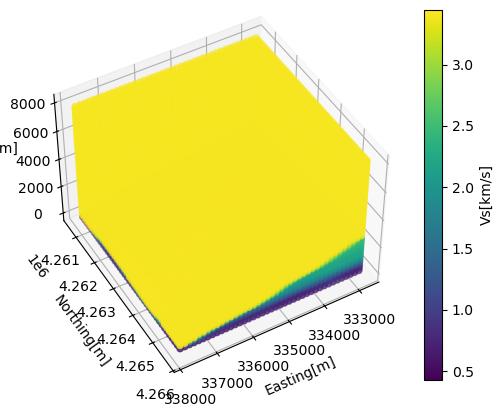

Widget(value='<iframe src="http://localhost:34373/index.html?ui=P_0x7b543547cb80_0&reconnect=auto" class="pyvi…

In [10]:
    # Visualizar com Matplotlib
    visualize(df, 'Easting[m]', 'Northing[m]', 'z[m]', 'Vs[km/s]', method="matplotlib", angle=(45, 60))
    
    # Visualizar com Pyvista
    visualize(df, 'Easting[m]', 'Northing[m]', 'z[m]', 'Vp[km/s]', method="pyvista")


## Plot With ElevationReference(m)

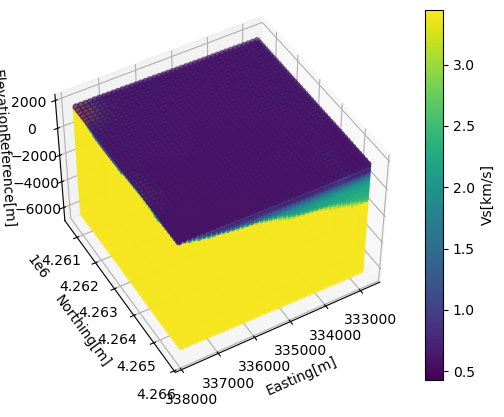

Widget(value='<iframe src="http://localhost:34373/index.html?ui=P_0x7b5436484f10_1&reconnect=auto" class="pyvi…

In [11]:
    # Visualizar com Matplotlib
    visualize(df, 'Easting[m]', 'Northing[m]', 'ElevationReference[m]', 'Vs[km/s]', method="matplotlib", angle=(45, 60))
    
    # Visualizar com Pyvista
    visualize(df, 'Easting[m]', 'Northing[m]', 'ElevationReference[m]', 'Vp[km/s]', method="pyvista")


## Interpolate 2D data with cota z(m)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_2d_property(dataframe, property_col, z_value, cmap="viridis", grid_res=200):
    """
    Visualiza a distribuição interpolada de uma propriedade em 2D a uma elevação z específica,
    com eixos configurados para 'x [km]' e 'y [km]' e valores adicionais em 'Easting [km]' e 'Northing [km]'.
    
    Args:
    dataframe (pd.DataFrame): DataFrame com os dados.
    property_col (str): Nome da coluna da propriedade para plotagem.
    z_value (float): Elevação z desejada.
    cmap (str): Mapa de cores para visualização.
    grid_res (int): Resolução da grade para interpolação.
    """
    # Encontrar a elevação mais próxima
    if z_value not in dataframe['z[m]'].values:
        closest_z = dataframe['z[m]'].iloc[(dataframe['z[m]'] - z_value).abs().argmin()]
        print(f"A elevação {z_value} não existe. Usando a mais próxima: {closest_z}")
        z_value = closest_z

    # Filtrar o DataFrame para a elevação especificada
    df_filtered = dataframe[dataframe['z[m]'] == z_value]
    if df_filtered.empty:
        print("Nenhum dado encontrado na elevação especificada.")
        return

    # Preparar os dados para interpolação
    x, y = df_filtered['x[m]'], df_filtered['y[m]']
    easting, northing = df_filtered['Easting[m]'], df_filtered['Northing[m]']
    values = df_filtered[property_col]

    # Criar uma grade regular para interpolação
    grid_x, grid_y = np.linspace(x.min(), x.max(), grid_res), np.linspace(y.min(), y.max(), grid_res)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)
    grid_values = griddata((x, y), values, (grid_x, grid_y), method='cubic')

    # Criar o gráfico principal
    fig, ax = plt.subplots(figsize=(8, 8))
    img = ax.imshow(grid_values, extent=(x.min(), x.max(), y.min(), y.max()), 
                    origin='lower', cmap=cmap, aspect='auto')
    contour = ax.contour(grid_x, grid_y, grid_values, levels=5, colors='black', linewidths=0.5)

    # Configurar eixos principais
    ax.set_xlabel("x [m]", fontsize=12)
    ax.set_ylabel("y [m]", fontsize=12)
    ax.set_xlim([x.min(), x.max()])
    ax.set_ylim([y.min(), y.max()])

    # Adicionar eixos superiores e direitos
    ax_top = ax.twiny()
    ax_right = ax.twinx()

    # Sincronizar limites dos eixos
    ax_top.set_xlim(ax.get_xlim())
    ax_right.set_ylim(ax.get_ylim())

    # Configurar rótulos e ticks dos eixos adicionais
    ax_top.set_xlabel("Easting [m]", fontsize=12)
    ax_right.set_ylabel("Northing [m]", fontsize=12)

    # Adicionar ticks para Easting e Northing baseados nos valores reais
    ax_top.set_xticks(np.linspace(x.min(), x.max(), 5))
    ax_top.set_xticklabels(np.round(np.linspace(easting.min(), easting.max(), 5), 1))
    ax_right.set_yticks(np.linspace(y.min(), y.max(), 5))
    ax_right.set_yticklabels(np.round(np.linspace(northing.min(), northing.max(), 5), 1))

    # Add color bar outside the plot
    cbar_ax = fig.add_axes([0.2, -0.08, 0.6, 0.03])  # [esquerda, inferior, largura, altura]
    cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(property_col, fontsize=12)

    # Título do gráfico
    ax.set_title(f"{property_col} at {z_value} km Depth (Interpolated)", fontsize=14)

    # Ajustar espaçamento manualmente
    fig.subplots_adjust(top=0.9, bottom=0.15)

    plt.show()


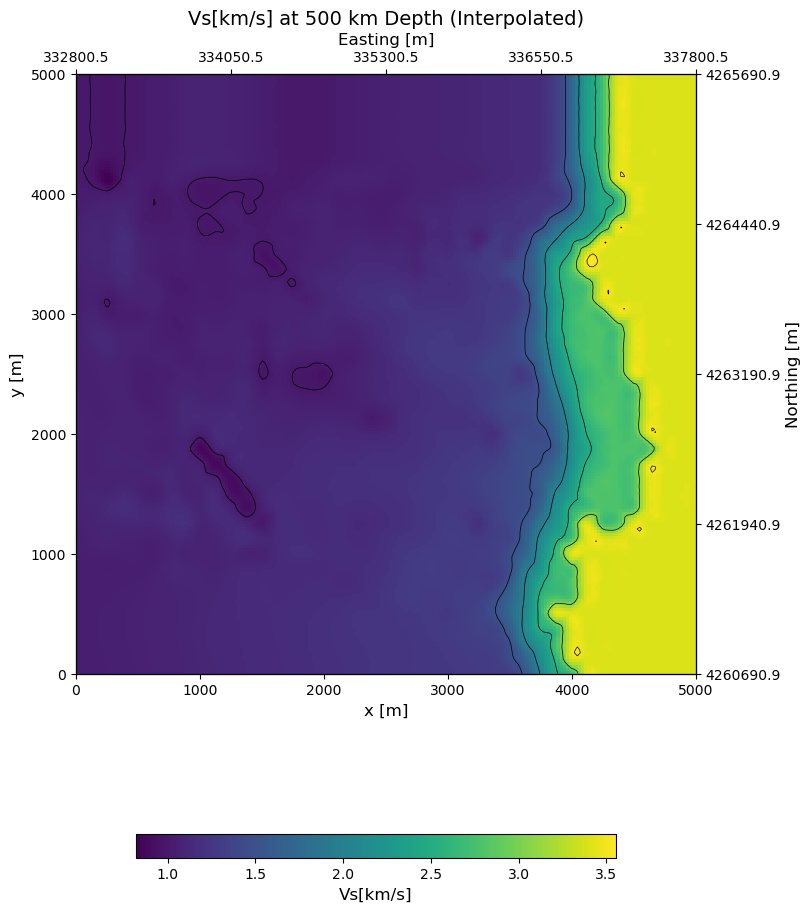

In [7]:
plot_2d_property(dataframe=df, property_col="Vs[km/s]", z_value=500)


## Interpolate 2D data with cota ElevationReference(m)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_2d_property(dataframe, property_col, z_value, cmap="viridis", grid_res=200):
    """
    Visualiza a distribuição interpolada de uma propriedade em 2D a uma elevação z específica,
    com eixos configurados para 'x [km]' e 'y [km]' e valores adicionais em 'Easting [km]' e 'Northing [km]'.
    
    Args:
    dataframe (pd.DataFrame): DataFrame com os dados.
    property_col (str): Nome da coluna da propriedade para plotagem.
    z_value (float): Elevação z desejada.
    cmap (str): Mapa de cores para visualização.
    grid_res (int): Resolução da grade para interpolação.
    """
    # Encontrar a elevação mais próxima
    if z_value not in dataframe['ElevationReference[m]'].values:
        closest_z = dataframe['ElevationReference[m]'].iloc[(dataframe['ElevationReference[m]'] - z_value).abs().argmin()]
        print(f"A elevação {z_value} não existe. Usando a mais próxima: {closest_z}")
        z_value = closest_z

    # Filtrar o DataFrame para a elevação especificada
    df_filtered = dataframe[dataframe['ElevationReference[m]'] == z_value]
    if df_filtered.empty:
        print("Nenhum dado encontrado na elevação especificada.")
        return

    # Preparar os dados para interpolação
    x, y = df_filtered['x[m]'], df_filtered['y[m]']
    easting, northing = df_filtered['Easting[m]'], df_filtered['Northing[m]']
    values = df_filtered[property_col]

    # Criar uma grade regular para interpolação
    grid_x, grid_y = np.linspace(x.min(), x.max(), grid_res), np.linspace(y.min(), y.max(), grid_res)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)
    grid_values = griddata((x, y), values, (grid_x, grid_y), method='cubic')

    # Criar o gráfico principal
    fig, ax = plt.subplots(figsize=(8, 8))
    img = ax.imshow(grid_values, extent=(x.min(), x.max(), y.min(), y.max()), 
                    origin='lower', cmap=cmap, aspect='auto')
    contour = ax.contour(grid_x, grid_y, grid_values, levels=5, colors='black', linewidths=0.5)

    # Configurar eixos principais
    ax.set_xlabel("x [m]", fontsize=12)
    ax.set_ylabel("y [m]", fontsize=12)
    ax.set_xlim([x.min(), x.max()])
    ax.set_ylim([y.min(), y.max()])

    # Adicionar eixos superiores e direitos
    ax_top = ax.twiny()
    ax_right = ax.twinx()

    # Sincronizar limites dos eixos
    ax_top.set_xlim(ax.get_xlim())
    ax_right.set_ylim(ax.get_ylim())

    # Configurar rótulos e ticks dos eixos adicionais
    ax_top.set_xlabel("Easting [m]", fontsize=12)
    ax_right.set_ylabel("Northing [m]", fontsize=12)

    # Adicionar ticks para Easting e Northing baseados nos valores reais
    ax_top.set_xticks(np.linspace(x.min(), x.max(), 5))
    ax_top.set_xticklabels(np.round(np.linspace(easting.min(), easting.max(), 5), 1))
    ax_right.set_yticks(np.linspace(y.min(), y.max(), 5))
    ax_right.set_yticklabels(np.round(np.linspace(northing.min(), northing.max(), 5), 1))

    # Add color bar outside the plot
    cbar_ax = fig.add_axes([0.2, -0.08, 0.6, 0.03])  # [esquerda, inferior, largura, altura]
    cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(property_col, fontsize=12)

    # Título do gráfico
    ax.set_title(f"{property_col} at {z_value} km Depth (Interpolated)", fontsize=14)

    # Ajustar espaçamento manualmente
    fig.subplots_adjust(top=0.9, bottom=0.15)

    plt.show()


In [9]:
plot_2d_property(dataframe=df, property_col="Vs[km/s]", z_value=1500)


A elevação 1500 não existe. Usando a mais próxima: 1499.93


QhullError: QH6214 qhull input error: not enough points(1) to construct initial simplex (need 4)

While executing:  | qhull d Qbb Qz Qc Q12 Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1199935185  delaunay  Qbbound-last  Qz-infinity-point  Qcoplanar-keep
  Q12-allow-wide  Qtriangulate  _pre-merge  _zero-centrum  Qinterior-keep
  _maxoutside  0


## Save VP(km/s) data, Depth in z[m]: 0m, 500m, 1000m, 1500m, 2000m, 2500m

In [9]:
import os

# Diretório onde os arquivos serão salvos
output_dir = "/home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vp/"

# Certificar-se de que o diretório existe, caso contrário, criá-lo
os.makedirs(output_dir, exist_ok=True)

# Lista de elevações (z[m])
elevations = [0, 500, 1000, 1500, 2000, 2500]


In [10]:
# Loop pelas elevações
for elevation in elevations:
    # Filtrar os dados para a elevação especificada
    df_filtered = df[df['z[m]'] == elevation]
    
    # Se o DataFrame filtrado não estiver vazio, salvar como CSV
    if not df_filtered.empty:
        # Reordenar as colunas
        df_filtered = df_filtered[['Easting[m]', 'Northing[m]', 'Vp[km/s]', 
                                   'x[m]', 'y[m]', 'z[m]', 'Vs[km/s]', 'Vp/Vs']]
        
        # Nome do arquivo
        file_name = f"vp_{elevation}_m.csv"
        file_path = os.path.join(output_dir, file_name)  # Caminho completo
        
        # Salvar o arquivo CSV
        df_filtered.to_csv(file_path, index=False)
        print(f"Arquivo salvo: {file_path}")
    else:
        print(f"Nenhum dado encontrado para a elevação {elevation} m.")

# Exibir mensagem final
print("Processamento concluído!")

Arquivo salvo: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vp/vp_0_m.csv
Arquivo salvo: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vp/vp_500_m.csv
Arquivo salvo: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vp/vp_1000_m.csv
Arquivo salvo: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vp/vp_1500_m.csv
Arquivo salvo: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vp/vp_2000_m.csv
Arquivo salvo: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vp/vp_2500_m.csv
Processamento concluído!


## Save Vs(km/s) data, Depth in z[m]: 0m, 500m, 1000m, 1500m, 2000m, 2500m

In [ ]:
import os

# Diretório onde os arquivos serão salvos
output_dir = "/home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vs/"

# Certificar-se de que o diretório existe, caso contrário, criá-lo
os.makedirs(output_dir, exist_ok=True)

# Lista de elevações (z[m])
elevations = [0, 500, 1000, 1500, 2000, 2500]


In [ ]:
# Loop pelas elevações
for elevation in elevations:
    # Filtrar os dados para a elevação especificada
    df_filtered = df[df['z[m]'] == elevation]
    
    # Se o DataFrame filtrado não estiver vazio, salvar como CSV
    if not df_filtered.empty:
        # Reordenar as colunas
        df_filtered = df_filtered[['Easting[m]', 'Northing[m]', 'Vs[km/s]', 
                                   'x[m]', 'y[m]', 'z[m]', 'Vp[km/s]', 'Vp/Vs']]
        
        # Nome do arquivo
        file_name = f"vp_{elevation}_m.csv"
        file_path = os.path.join(output_dir, file_name)  # Caminho completo
        
        # Salvar o arquivo CSV
        df_filtered.to_csv(file_path, index=False)
        print(f"Arquivo salvo: {file_path}")
    else:
        print(f"Nenhum dado encontrado para a elevação {elevation} m.")

# Exibir mensagem final
print("Processamento concluído!")

## Save VP(km/s) data, Depth in ElevationReference[m]: 1500m, 1000m, 500m, 0m, -500m, -1000m

In [31]:
import pandas as pd
import os

def filter_and_save_vp_data(df, target_elevations, maxdif, save=True, save_dir="/home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vp/"):
    """
    Filtra os dados para encontrar os valores mais próximos das cotas alvo no ElevationReference[m] 
    dentro de um limite máximo de diferença (maxdif). Remove duplicatas de coordenadas (Easting, Northing),
    mantendo o valor mais próximo da cota alvo. Ordena as colunas e salva os dados.

    Args:
    - df (pd.DataFrame): DataFrame original contendo os dados sísmicos.
    - target_elevations (list): Lista de cotas alvo para filtrar os dados.
    - maxdif (float): Diferença máxima permitida entre target_elevation e ElevationReference[m].
    - save (bool): Se True, salva os arquivos no diretório especificado.
    - save_dir (str): Diretório onde os arquivos serão salvos.

    Returns:
    - dict: Dicionário contendo os DataFrames filtrados para cada elevação.
    """
    
    results = {}  # Dicionário para armazenar os DataFrames filtrados

    for target_elevation in target_elevations:
        print(f"\n🔹 Processando dados para ElevationReference = {target_elevation}m...")
        
        # Filtrar os dados dentro da faixa de ± maxdif da cota desejada
        df_filtered = df[(df['ElevationReference[m]'] >= target_elevation - maxdif) & 
                         (df['ElevationReference[m]'] <= target_elevation + maxdif)].copy()
        
        if df_filtered.empty:
            print(f"⚠️ Nenhum dado encontrado na faixa de ±{maxdif}m de {target_elevation}m.")
            continue

        # Selecionar a linha com menor diferença para cada par (Easting, Northing)
        df_filtered["diff"] = (df_filtered["ElevationReference[m]"] - target_elevation).abs()
        df_filtered = df_filtered.sort_values("diff").drop_duplicates(subset=["Easting[m]", "Northing[m]"], keep="first")
        df_filtered.drop(columns=["diff"], inplace=True)

        # Ordenar as colunas na sequência desejada
        column_order = ['Easting[m]', 'Northing[m]', 'Vp[km/s]', 'ElevationReference[m]', 'ElevationLidar[m]1', 
                        'x[m]', 'y[m]', 'z[m]', 'Vs[km/s]', 'Vp/Vs']
        df_filtered = df_filtered[column_order]

        # Resetar os índices para exibição correta no DataFrame
        df_filtered.reset_index(drop=True, inplace=True)

        # Ajustar o nome do arquivo e DataFrame para números negativos
        elevation_name = f"minus{abs(int(target_elevation))}" if target_elevation < 0 else f"{int(target_elevation)}"
        filename = f"vp_{elevation_name}_m.csv"
        file_path = os.path.join(save_dir, filename)

        # Salvar o arquivo sem índices
        if save:
            os.makedirs(save_dir, exist_ok=True)  # Garante que o diretório existe
            df_filtered.to_csv(file_path, sep=",", index=False, float_format="%.3f")  # Salva sem índice
            print(f"✅ Arquivo salvo em: {file_path}")

        # Criar um DataFrame nomeado dinamicamente e armazená-lo no dicionário
        df_name = f"vp_{elevation_name}_m"
        results[df_name] = df_filtered
        globals()[df_name] = df_filtered  # Torna acessível no escopo global

    # Exibir um dos DataFrames para conferência (o primeiro da lista)
    if results:
        first_key = list(results.keys())[0]
        print(f"\n🔹 Exibindo dados do primeiro resultado: {first_key}")
        print(results[first_key].head())  # Mostra as primeiras linhas do DataFrame

    return results  # Retorna o dicionário com todos os DataFrames gerados


In [32]:
target_elevations = [1500, 1000, 500, 0, -500, -1000]
filtered_dfs = filter_and_save_vp_data(df, target_elevations, maxdif=60)



🔹 Processando dados para ElevationReference = 1500m...
✅ Arquivo salvo em: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vp/vp_1500_m.csv

🔹 Processando dados para ElevationReference = 1000m...
✅ Arquivo salvo em: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vp/vp_1000_m.csv

🔹 Processando dados para ElevationReference = 500m...
✅ Arquivo salvo em: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vp/vp_500_m.csv

🔹 Processando dados para ElevationReference = 0m...
✅ Arquivo salvo em: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vp/vp_0_m.csv

🔹 Processando dados para ElevationReference = -500m...
✅ Arquivo salvo em: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/

### Visualize VP


🔹 Processando dados para ElevationReference = 1500m...

🔹 Processando dados para ElevationReference = 1000m...

🔹 Processando dados para ElevationReference = 500m...

🔹 Processando dados para ElevationReference = 0m...

🔹 Processando dados para ElevationReference = -500m...

🔹 Processando dados para ElevationReference = -1000m...

🔹 Exibindo dados do primeiro resultado: vp_1500_m
   Easting[m]  Northing[m]  Vp[km/s]  ElevationReference[m]  \
0  334050.507  4263440.918     1.592                1499.93   
1  333050.507  4260690.918     1.640                1499.92   
2  333800.507  4262690.918     1.615                1499.85   
3  336800.507  4263690.918     1.953                1499.84   
4  336800.507  4263815.918     1.924                1500.23   

   ElevationLidar[m]1    x[m]    y[m]   z[m]  Vs[km/s]  Vp/Vs  
0         1624.934082  1250.0  2750.0  125.0     0.854  1.864  
1         1624.920898   250.0     0.0  125.0     0.879  1.866  
2         1624.848145  1000.0  2000.0  125.0 

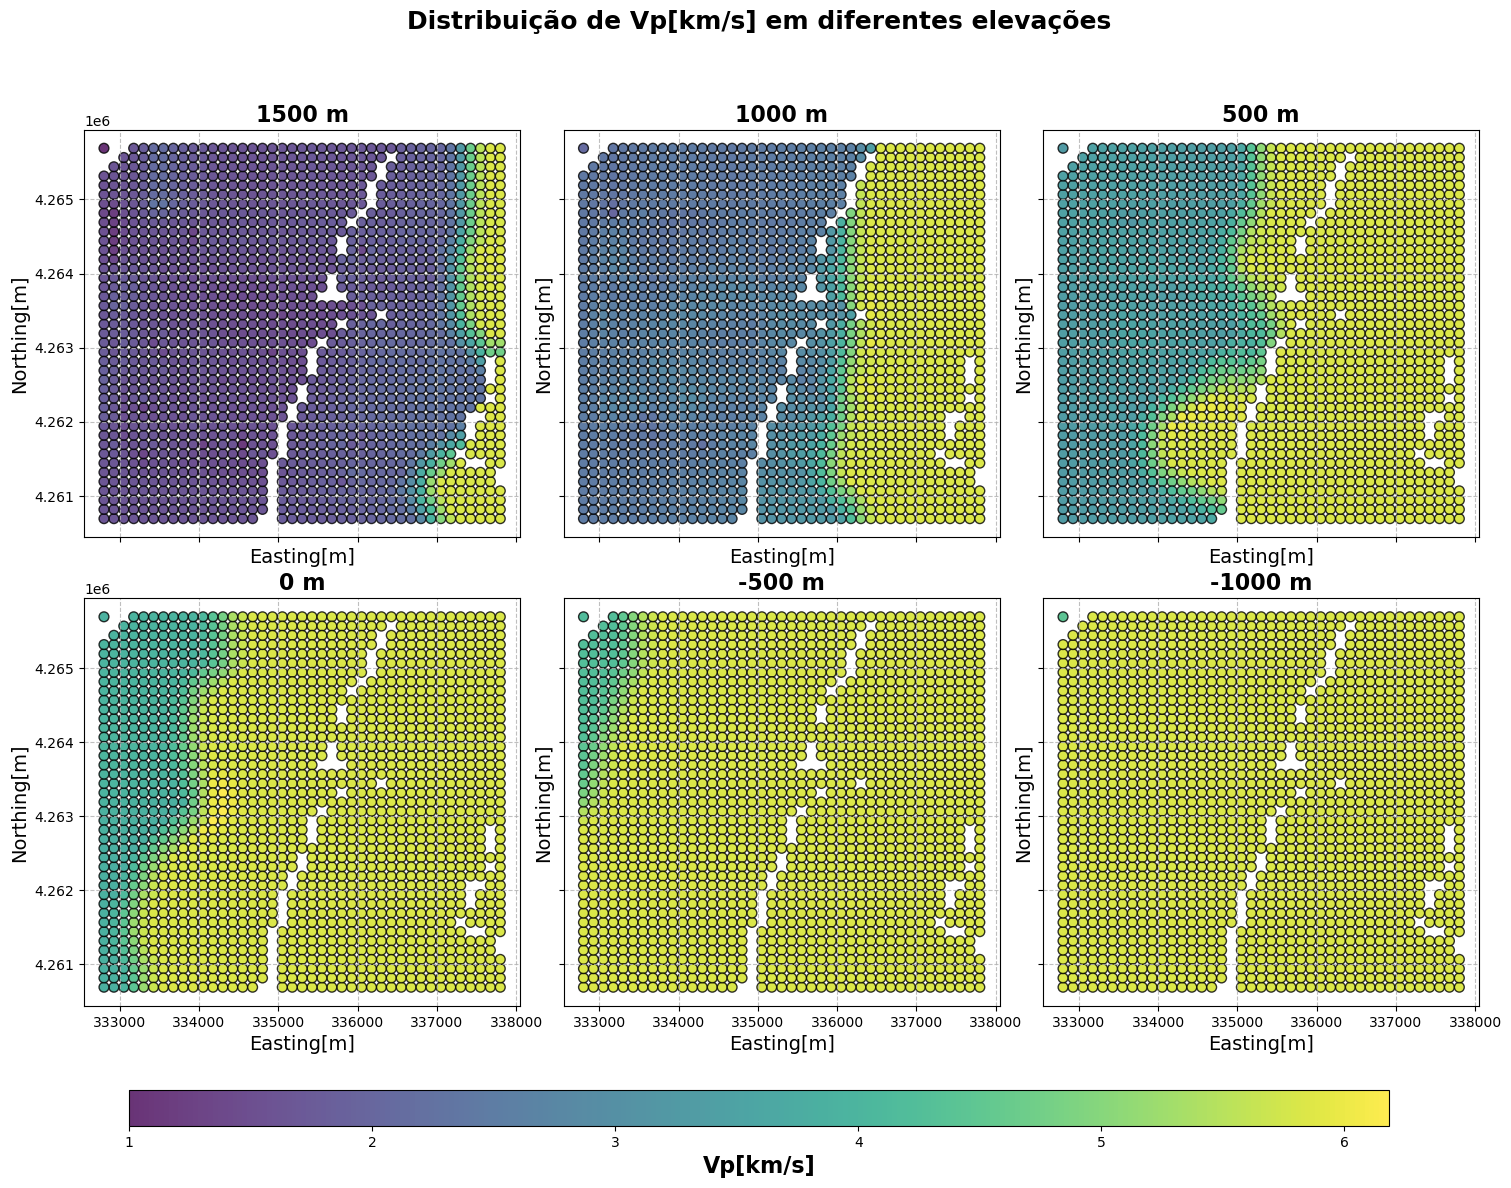

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_vp_subplots(dataframes, property_col="Vp[km/s]", font_sizes=None, cbar_pad=0.08, wspace=0.3, hspace=0.3, grid_alpha=0.5):
    """
    Plota múltiplos DataFrames em subplots, permitindo visualizar uma propriedade física
    em diferentes níveis de elevação. Usa um colormap para representar os valores.

    Args:
    - dataframes (dict): Dicionário com os DataFrames, onde as chaves são os nomes dos DataFrames.
    - property_col (str): Nome da coluna a ser usada como cor no colormap.
    - font_sizes (dict): Dicionário com os tamanhos de fonte, ex: {"title": 16, "axis": 12, "subplot_title": 14, "cbar": 14}.
    - cbar_pad (float): Define o deslocamento da barra de cores na vertical.
    - wspace (float): Espaçamento horizontal entre subplots.
    - hspace (float): Espaçamento vertical entre subplots.
    - grid_alpha (float): Transparência do grid nos subplots.

    Returns:
    - Exibe um gráfico com subplots representando os diferentes DataFrames.
    """

    # Definir tamanhos de fonte padrão se não forem fornecidos
    if font_sizes is None:
        font_sizes = {"title": 16, "axis": 12, "subplot_title": 14, "cbar": 14}

    num_plots = len(dataframes)  # Número de DataFrames
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)  # 6 subplots (2x3)
    fig.suptitle(f"Distribuição de {property_col} em diferentes elevações", fontsize=font_sizes["title"], fontweight='bold')

    cmap = plt.cm.viridis  # Colormap para os valores da propriedade

    # Criar uma normalização global para manter a escala uniforme em todos os subplots
    all_values = np.concatenate([df[property_col].values for df in dataframes.values()])
    norm = plt.Normalize(vmin=all_values.min(), vmax=all_values.max())

    # Percorre os DataFrames e plota nos subplots
    for ax, (df_name, df) in zip(axes.flatten(), dataframes.items()):
        sc = ax.scatter(df["Easting[m]"], df["Northing[m]"], c=df[property_col], cmap=cmap, norm=norm, s=50, edgecolor="black", alpha=0.8)

        # Substituir "minus" por "-" no nome do subplot
        subplot_title = df_name.replace("vp_", "").replace("_m", " m").replace("minus", "-")
        ax.set_title(subplot_title, fontsize=font_sizes["subplot_title"], fontweight='bold')

        # Configuração dos eixos
        ax.set_xlabel("Easting[m]", fontsize=font_sizes["axis"])
        ax.set_ylabel("Northing[m]", fontsize=font_sizes["axis"])

        # Adding grid with transparency
        ax.grid(True, linestyle="--", alpha=grid_alpha)

    # Adicionar uma barra de cores única abaixo de todos os plots
    cbar_ax = fig.add_axes([0.15, cbar_pad, 0.7, 0.03])  # Ajuste da posição da barra de cores
    cbar = plt.colorbar(sc, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(property_col, fontsize=font_sizes["cbar"], fontweight='bold')

    # Ajustar espaçamento entre subplots
    plt.subplots_adjust(wspace=wspace, hspace=hspace, bottom=0.15)  # Ajusta a distância entre subplots

    plt.show()

# Exemplo de uso:
target_elevations = [1500, 1000, 500, 0, -500, -1000]
filtered_dfs = filter_and_save_vp_data(df, target_elevations, maxdif=60, save=False)

# Definir tamanhos de fonte e configurações extras
font_config = {"title": 18, "axis": 14, "subplot_title": 16, "cbar": 16}

# Plotar os subplots usando os DataFrames filtrados
plot_vp_subplots(filtered_dfs, property_col="Vp[km/s]", font_sizes=font_config, cbar_pad=0.05, wspace=0.1, hspace=0.15, grid_alpha=0.8)


### Interpolate VP

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.transform import from_origin
from scipy.interpolate import griddata
from pykrige.ok import OrdinaryKriging

def interpolate_and_save_raster(df, property_col="Vp[km/s]", method="kriging", resolution=200, 
                                save_dir="./", save_tiff=True, save_variogram=True):
    """
    Interpola os dados usando diferentes métodos e salva o resultado como um raster .tiff.
    Também gera um semivariograma caso o método escolhido seja Krigagem.

    Args:
    - df (pd.DataFrame): DataFrame com os dados da elevação.
    - property_col (str): Nome da coluna a ser interpolada.
    - method (str): Método de interpolação ("idw", "rbf", "spline", "kriging").
    - resolution (int): Número de pixels na interpolação (quanto maior, mais detalhado).
    - save_dir (str): Diretório para salvar o raster.
    - save_tiff (bool): Se True, salva como um arquivo .tiff.
    - save_variogram (bool): Se True, salva o gráfico de semivariograma para Krigagem.

    Returns:
    - Interpolated grid (numpy array), extent (tuple)
    """

    # Criar diretório se não existir
    os.makedirs(save_dir, exist_ok=True)

    # Criar um nome limpo para salvar os arquivos
    property_filename = "vp"  # Sempre usará "vp" como nome do arquivo

    # Criar o grid baseado nos dados
    x_min, x_max = df["Easting[m]"].min(), df["Easting[m]"].max()
    y_min, y_max = df["Northing[m]"].min(), df["Northing[m]"].max()

    x_grid = np.linspace(x_min, x_max, resolution)
    y_grid = np.linspace(y_min, y_max, resolution)
    X, Y = np.meshgrid(x_grid, y_grid)

    points = df[["Easting[m]", "Northing[m]"]].values
    values = df[property_col].values

    # Cálculo da resolução espacial entre pixels
    pixel_size_x = (x_max - x_min) / resolution
    pixel_size_y = (y_max - y_min) / resolution
    print(f"📏 Resolução espacial: {pixel_size_x:.3f} x {pixel_size_y:.3f} metros por pixel")

    # Interpolação escolhida
    if method == "idw":
        from scipy.spatial import cKDTree
        tree = cKDTree(points)
        dists, idxs = tree.query(np.vstack([X.ravel(), Y.ravel()]).T, k=4)
        weights = 1 / (dists + 1e-10)  # Evita divisão por zero
        Z = np.sum(weights * values[idxs], axis=1) / np.sum(weights, axis=1)

    elif method == "rbf":
        from scipy.interpolate import Rbf
        rbf = Rbf(points[:, 0], points[:, 1], values, function="linear")
        Z = rbf(X, Y)

    elif method == "spline":
        Z = griddata(points, values, (X, Y), method="cubic")

    elif method == "kriging":
        OK = OrdinaryKriging(
            df["Easting[m]"], df["Northing[m]"], df[property_col],
            variogram_model="spherical", verbose=False, enable_plotting=False
        )
        Z, _ = OK.execute("grid", x_grid, y_grid)

        # Gerar e salvar o semivariograma manualmente
        if save_variogram:
            lags = np.linspace(0, np.max(OK.lags), len(OK.semivariance))
            plt.figure(figsize=(8, 5))
            plt.scatter(lags, OK.semivariance, c="blue", label="Semivariância Experimental")
            plt.plot(lags, OK.variogram_function(OK.variogram_model_parameters, lags), c="red", label="Modelo Ajustado")
            plt.xlabel("Distância entre pontos (m)")
            plt.ylabel("Semivariância")
            plt.title(f"Semivariograma - {property_col}")
            plt.legend()
            plt.grid(True)

            variogram_path = f"{save_dir}/{property_filename}_variogram.png"
            plt.savefig(variogram_path, dpi=300)
            print(f"📈 Semivariograma salvo em: {variogram_path}")
            plt.show()

    else:
        raise ValueError("Método de interpolação inválido. Escolha: 'idw', 'rbf', 'spline' ou 'kriging'.")

    Z = Z.reshape(X.shape)

    # Salvar como raster .tiff
    if save_tiff:
        raster_path = f"{save_dir}/{property_filename}_{method}.tiff"
        transform = from_origin(x_min, y_max, pixel_size_x, pixel_size_y)
        
        with rasterio.open(
            raster_path, "w", driver="GTiff",
            height=Z.shape[0], width=Z.shape[1],
            count=1, dtype=Z.dtype,
            crs="EPSG:26912", transform=transform
        ) as dst:
            dst.write(Z, 1)

        print(f"🗺️ Raster salvo em: {raster_path}")

    return Z, (x_min, x_max, y_min, y_max)

# Exemplo de uso:
save_directory = "/home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vp"

df_example = vp_1500_m  # ✅ Usa diretamente o DataFrame existente
interpolated_grid, extent = interpolate_and_save_raster(
    df_example, method="kriging", resolution=200, save_dir=save_directory, save_tiff=True, save_variogram=True
)
    

NameError: name 'vp_1500_m' is not defined

## Save VS(km/s) data, Depth in ElevationReference[m]: 1500m, 1000m, 500m, 0m, -500m, -1000m

In [47]:
import pandas as pd
import os

def filter_and_save_vp_data(df, target_elevations, maxdif, save=True, save_dir="/home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vs/"):
    """
    Filtra os dados para encontrar os valores mais próximos das cotas alvo no ElevationReference[m] 
    dentro de um limite máximo de diferença (maxdif). Remove duplicatas de coordenadas (Easting, Northing),
    mantendo o valor mais próximo da cota alvo. Ordena as colunas e salva os dados.

    Args:
    - df (pd.DataFrame): DataFrame original contendo os dados sísmicos.
    - target_elevations (list): Lista de cotas alvo para filtrar os dados.
    - maxdif (float): Diferença máxima permitida entre target_elevation e ElevationReference[m].
    - save (bool): Se True, salva os arquivos no diretório especificado.
    - save_dir (str): Diretório onde os arquivos serão salvos.

    Returns:
    - dict: Dicionário contendo os DataFrames filtrados para cada elevação.
    """
    
    results = {}  # Dicionário para armazenar os DataFrames filtrados

    for target_elevation in target_elevations:
        print(f"\n🔹 Processando dados para ElevationReference = {target_elevation}m...")
        
        # Filtrar os dados dentro da faixa de ± maxdif da cota desejada
        df_filtered = df[(df['ElevationReference[m]'] >= target_elevation - maxdif) & 
                         (df['ElevationReference[m]'] <= target_elevation + maxdif)].copy()
        
        if df_filtered.empty:
            print(f"⚠️ Nenhum dado encontrado na faixa de ±{maxdif}m de {target_elevation}m.")
            continue

        # Selecionar a linha com menor diferença para cada par (Easting, Northing)
        df_filtered["diff"] = (df_filtered["ElevationReference[m]"] - target_elevation).abs()
        df_filtered = df_filtered.sort_values("diff").drop_duplicates(subset=["Easting[m]", "Northing[m]"], keep="first")
        df_filtered.drop(columns=["diff"], inplace=True)

        # Ordenar as colunas na sequência desejada
        column_order = ['Easting[m]', 'Northing[m]', 'Vs[km/s]', 'ElevationReference[m]', 'ElevationLidar[m]1', 
                        'x[m]', 'y[m]', 'z[m]', 'Vp[km/s]', 'Vp/Vs']
        df_filtered = df_filtered[column_order]

        # Resetar os índices para exibição correta no DataFrame
        df_filtered.reset_index(drop=True, inplace=True)

        # Ajustar o nome do arquivo e DataFrame para números negativos
        elevation_name = f"minus{abs(int(target_elevation))}" if target_elevation < 0 else f"{int(target_elevation)}"
        filename = f"vp_{elevation_name}_m.csv"
        file_path = os.path.join(save_dir, filename)

        # Salvar o arquivo sem índices
        if save:
            os.makedirs(save_dir, exist_ok=True)  # Garante que o diretório existe
            df_filtered.to_csv(file_path, sep=",", index=False, float_format="%.3f")  # Salva sem índice
            print(f"✅ Arquivo salvo em: {file_path}")

        # Criar um DataFrame nomeado dinamicamente e armazená-lo no dicionário
        df_name = f"vs_{elevation_name}_m"
        results[df_name] = df_filtered
        globals()[df_name] = df_filtered  # Torna acessível no escopo global

    # Exibir um dos DataFrames para conferência (o primeiro da lista)
    if results:
        first_key = list(results.keys())[0]
        print(f"\n🔹 Exibindo dados do primeiro resultado: {first_key}")
        print(results[first_key].head())  # Mostra as primeiras linhas do DataFrame

    return results  # Retorna o dicionário com todos os DataFrames gerados


In [48]:
target_elevations = [1500, 1000, 500, 0, -500, -1000]
filtered_dfs = filter_and_save_vp_data(df, target_elevations, maxdif=60)



🔹 Processando dados para ElevationReference = 1500m...
✅ Arquivo salvo em: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vs/vp_1500_m.csv

🔹 Processando dados para ElevationReference = 1000m...
✅ Arquivo salvo em: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vs/vp_1000_m.csv

🔹 Processando dados para ElevationReference = 500m...
✅ Arquivo salvo em: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vs/vp_500_m.csv

🔹 Processando dados para ElevationReference = 0m...
✅ Arquivo salvo em: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/model_velocity/vs/vp_0_m.csv

🔹 Processando dados para ElevationReference = -500m...
✅ Arquivo salvo em: /home/marcus/Documentos/qualificacao_mestrado/codigo_marcus/codigo_marcus/codigo_modelo_temperatura/

### Visualize VS


🔹 Processando dados para ElevationReference = 1500m...

🔹 Processando dados para ElevationReference = 1000m...

🔹 Processando dados para ElevationReference = 500m...

🔹 Processando dados para ElevationReference = 0m...

🔹 Processando dados para ElevationReference = -500m...

🔹 Processando dados para ElevationReference = -1000m...

🔹 Exibindo dados do primeiro resultado: vs_1500_m
   Easting[m]  Northing[m]  Vs[km/s]  ElevationReference[m]  \
0  334050.507  4263440.918     0.854                1499.93   
1  333050.507  4260690.918     0.879                1499.92   
2  333800.507  4262690.918     0.866                1499.85   
3  336800.507  4263690.918     0.823                1499.84   
4  336800.507  4263815.918     0.811                1500.23   

   ElevationLidar[m]1    x[m]    y[m]   z[m]  Vp[km/s]  Vp/Vs  
0         1624.934082  1250.0  2750.0  125.0     1.592  1.864  
1         1624.920898   250.0     0.0  125.0     1.640  1.866  
2         1624.848145  1000.0  2000.0  125.0 

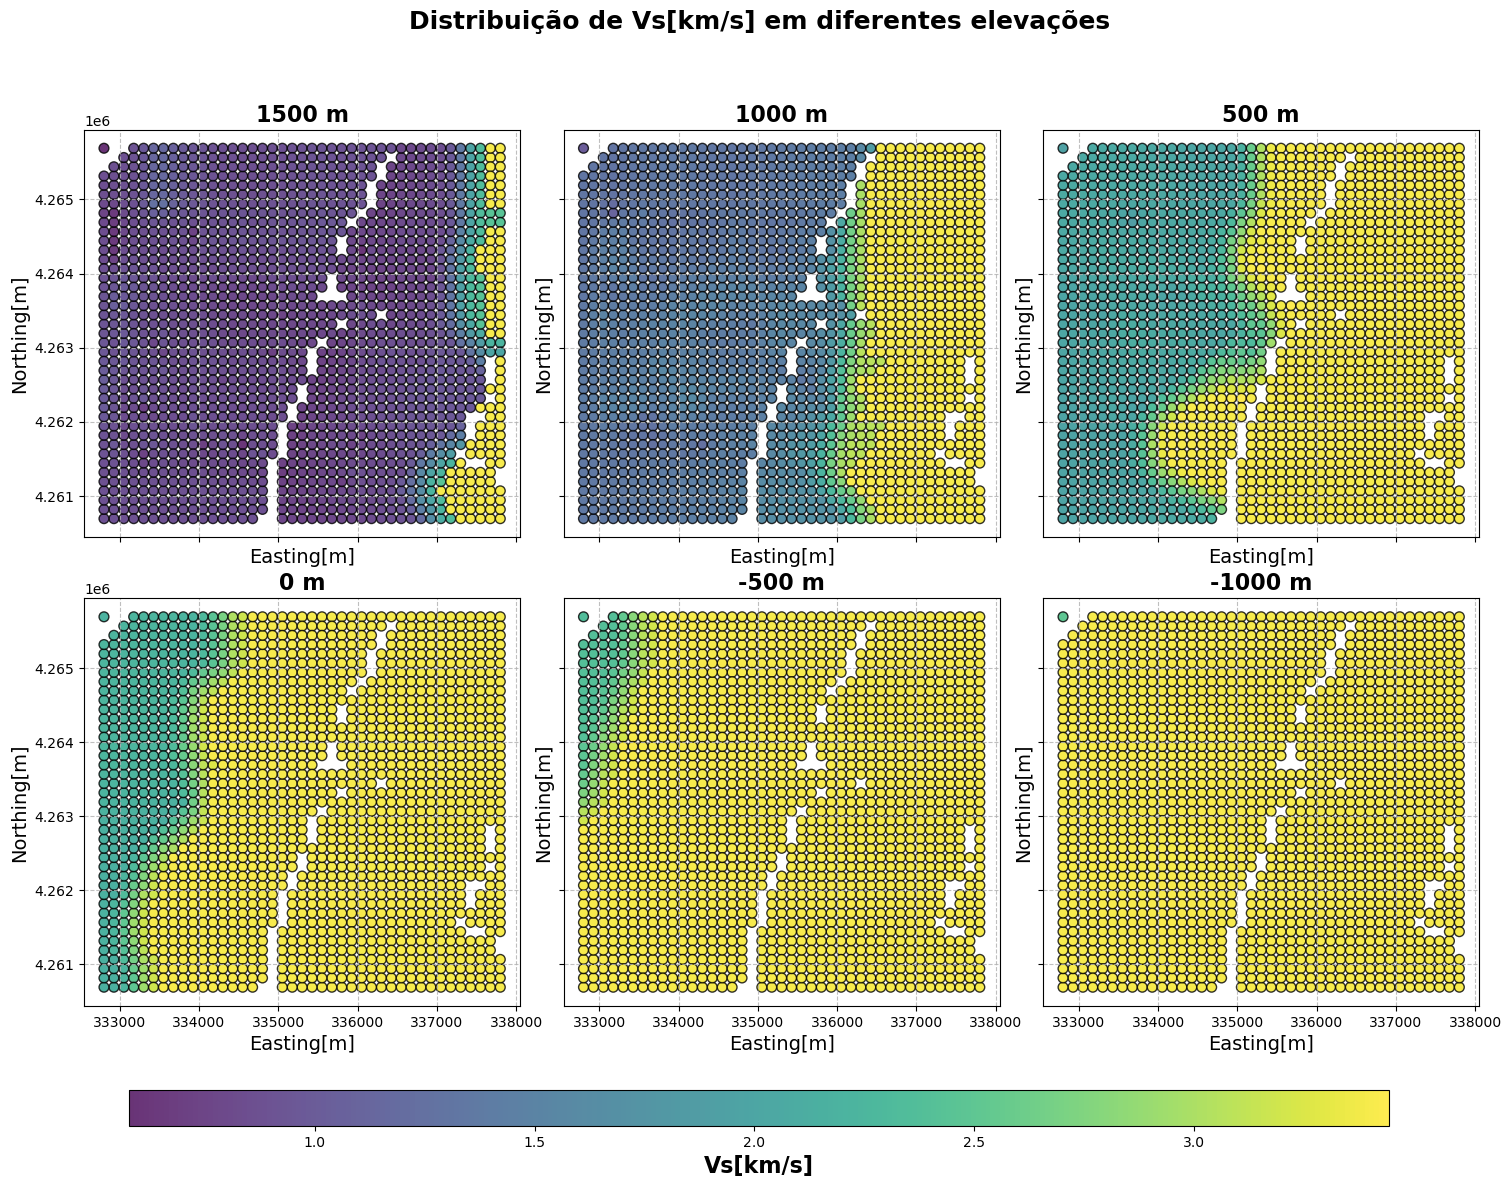

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def plot_vp_subplots(dataframes, property_col="Vs[km/s]", font_sizes=None, cbar_pad=0.08, wspace=0.3, hspace=0.3, grid_alpha=0.5):
    """
    Plota múltiplos DataFrames em subplots, permitindo visualizar uma propriedade física
    em diferentes níveis de elevação. Usa um colormap para representar os valores.

    Args:
    - dataframes (dict): Dicionário com os DataFrames, onde as chaves são os nomes dos DataFrames.
    - property_col (str): Nome da coluna a ser usada como cor no colormap.
    - font_sizes (dict): Dicionário com os tamanhos de fonte, ex: {"title": 16, "axis": 12, "subplot_title": 14, "cbar": 14}.
    - cbar_pad (float): Define o deslocamento da barra de cores na vertical.
    - wspace (float): Espaçamento horizontal entre subplots.
    - hspace (float): Espaçamento vertical entre subplots.
    - grid_alpha (float): Transparência do grid nos subplots.

    Returns:
    - Exibe um gráfico com subplots representando os diferentes DataFrames.
    """

    # Definir tamanhos de fonte padrão se não forem fornecidos
    if font_sizes is None:
        font_sizes = {"title": 16, "axis": 12, "subplot_title": 14, "cbar": 14}

    num_plots = len(dataframes)  # Número de DataFrames
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharex=True, sharey=True)  # 6 subplots (2x3)
    fig.suptitle(f"Distribuição de {property_col} em diferentes elevações", fontsize=font_sizes["title"], fontweight='bold')

    cmap = plt.cm.viridis  # Colormap para os valores da propriedade

    # Criar uma normalização global para manter a escala uniforme em todos os subplots
    all_values = np.concatenate([df[property_col].values for df in dataframes.values()])
    norm = plt.Normalize(vmin=all_values.min(), vmax=all_values.max())

    # Percorre os DataFrames e plota nos subplots
    for ax, (df_name, df) in zip(axes.flatten(), dataframes.items()):
        sc = ax.scatter(df["Easting[m]"], df["Northing[m]"], c=df[property_col], cmap=cmap, norm=norm, s=50, edgecolor="black", alpha=0.8)

        # Substituir "minus" por "-" no nome do subplot
        subplot_title = df_name.replace("vs_", "").replace("_m", " m").replace("minus", "-")
        ax.set_title(subplot_title, fontsize=font_sizes["subplot_title"], fontweight='bold')

        # Configuração dos eixos
        ax.set_xlabel("Easting[m]", fontsize=font_sizes["axis"])
        ax.set_ylabel("Northing[m]", fontsize=font_sizes["axis"])

        # Adding grid with transparency
        ax.grid(True, linestyle="--", alpha=grid_alpha)

    # Adicionar uma barra de cores única abaixo de todos os plots
    cbar_ax = fig.add_axes([0.15, cbar_pad, 0.7, 0.03])  # Ajuste da posição da barra de cores
    cbar = plt.colorbar(sc, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(property_col, fontsize=font_sizes["cbar"], fontweight='bold')

    # Ajustar espaçamento entre subplots
    plt.subplots_adjust(wspace=wspace, hspace=hspace, bottom=0.15)  # Ajusta a distância entre subplots

    plt.show()

# Exemplo de uso:
target_elevations = [1500, 1000, 500, 0, -500, -1000]
filtered_dfs = filter_and_save_vp_data(df, target_elevations, maxdif=60, save=False)

# Definir tamanhos de fonte e configurações extras
font_config = {"title": 18, "axis": 14, "subplot_title": 16, "cbar": 16}

# Plotar os subplots usando os DataFrames filtrados
plot_vp_subplots(filtered_dfs, property_col="Vs[km/s]", font_sizes=font_config, cbar_pad=0.05, wspace=0.1, hspace=0.15, grid_alpha=0.8)


## Load Local Wells

In [1]:
import pandas as pd

# Dados para o dataframe
data = {
    "well": ["56_32", "58_32", "78A_32", "78_B_32", "16A_32", "16B_32"],
    "Easting_(x)_[m]": [335504.27, 335450.98, 335780.84, 335865.45, 334641.18, 334642.08],
    "Northing_(y)_[m]": [4263426.18, 4263037.90, 4262991.99, 4262983.52, 4263443.69, 4263471.06]
}

# Criar o dataframe
local_well_df = pd.DataFrame(data)

# Exibir o dataframe
print(local_well_df)


      well  Easting_(x)_[m]  Northing_(y)_[m]
0    56_32        335504.27        4263426.18
1    58_32        335450.98        4263037.90
2   78A_32        335780.84        4262991.99
3  78_B_32        335865.45        4262983.52
4   16A_32        334641.18        4263443.69
5   16B_32        334642.08        4263471.06


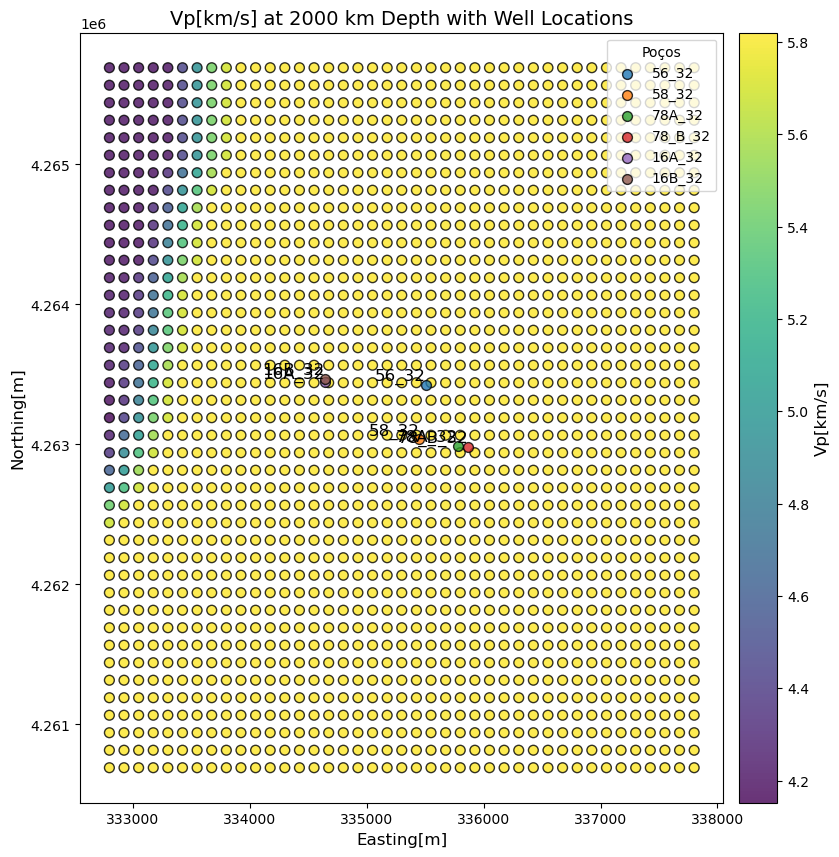

In [43]:
import matplotlib.pyplot as plt

def plot_points_with_wells(dataframe, property_col, z_value, well_df, font_size=10, circle_size=100):
    """
    Plota os pontos de dados da propriedade em 2D junto com as localizações dos poços no mesmo gráfico.
    
    Args:
    dataframe (pd.DataFrame): DataFrame com os dados da propriedade.
    property_col (str): Nome da coluna da propriedade para plotagem.
    z_value (float): Elevação z desejada.
    well_df (pd.DataFrame): DataFrame com os dados dos poços.
    font_size (int): Tamanho da fonte dos nomes dos poços.
    circle_size (int): Tamanho dos círculos representando os poços.
    """
    # Encontrar a elevação mais próxima
    if z_value not in dataframe['z[m]'].values:
        closest_z = dataframe['z[m]'].iloc[(dataframe['z[m]'] - z_value).abs().argmin()]
        print(f"A elevação {z_value} não existe. Usando a mais próxima: {closest_z}")
        z_value = closest_z

    # Filtrar o DataFrame para a elevação especificada
    df_filtered = dataframe[dataframe['z[m]'] == z_value]
    if df_filtered.empty:
        print("Nenhum dado encontrado na elevação especificada.")
        return

    # Preparar os dados
    x, y = df_filtered['Easting[m]'], df_filtered['Northing[m]']
    values = df_filtered[property_col]

    # Criar o gráfico
    fig, ax = plt.subplots(figsize=(10, 10))
    scatter = ax.scatter(x, y, c=values, cmap="viridis", s=50, alpha=0.8, edgecolor='black')
    
    # Adicionar os poços ao gráfico
    colors = plt.cm.tab10(range(len(well_df)))
    for i, row in well_df.iterrows():
        ax.scatter(row["Easting_(x)_[m]"], row["Northing_(y)_[m]"], 
                   color=colors[i], s=circle_size, label=row["well"], alpha=0.8, edgecolor='black')
        ax.text(row["Easting_(x)_[m]"], row["Northing_(y)_[m]"], 
                row["well"], fontsize=font_size, ha='right', va='bottom')

    # Configurar eixos
    ax.set_xlabel("Easting[m]", fontsize=12)
    ax.set_ylabel("Northing[m]", fontsize=12)
    ax.set_title(f"{property_col} at {z_value} km Depth with Well Locations", fontsize=14)
    
    # Add color bar
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label(property_col, fontsize=12)

    # Adicionar legenda
    ax.legend(title="Poços", fontsize=10, loc='upper right')

    plt.show()

# Exemplo de chamada da função
plot_points_with_wells(dataframe=df, property_col="Vp[km/s]", z_value=2000, well_df=local_well_df, font_size=12, circle_size=50)


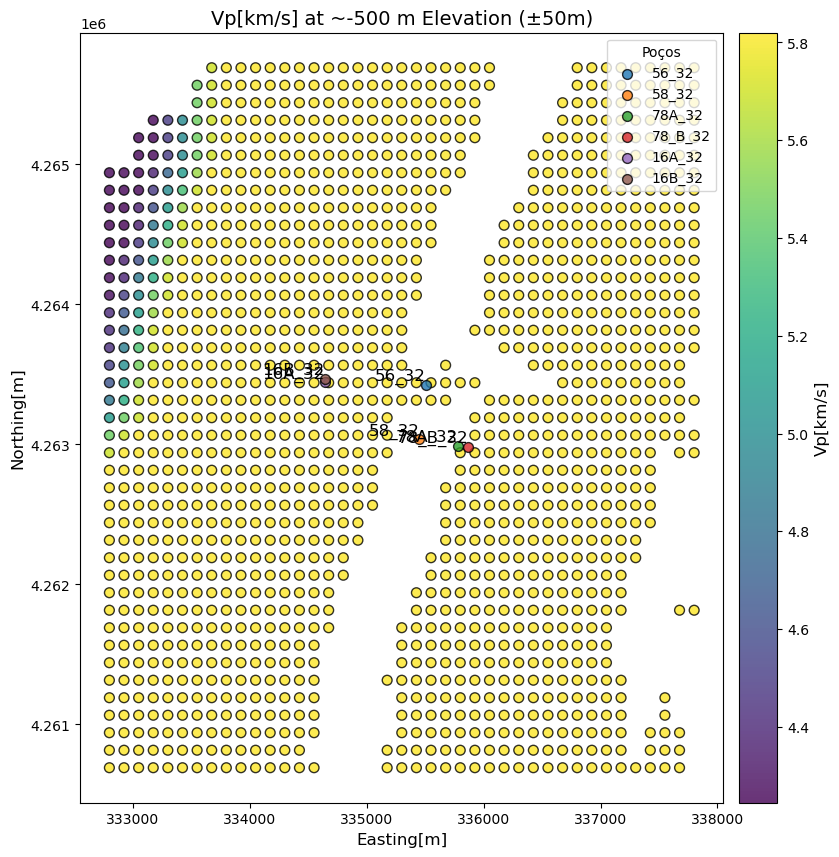

In [54]:
import matplotlib.pyplot as plt

def plot_points_with_wells(dataframe, property_col, z_value, well_df, font_size=10, circle_size=100, tolerance=50):
    """
    Plota os pontos de dados da propriedade em 2D junto com as localizações dos poços no mesmo gráfico.

    Args:
    dataframe (pd.DataFrame): DataFrame com os dados da propriedade.
    property_col (str): Nome da coluna da propriedade para plotagem.
    z_value (float): Elevação z desejada.
    well_df (pd.DataFrame): DataFrame com os dados dos poços.
    font_size (int): Tamanho da fonte dos nomes dos poços.
    circle_size (int): Tamanho dos círculos representando os poços.
    tolerance (float): Faixa de variação permitida (±50m por padrão).
    """
    # Filtrar os dados que estão dentro da faixa de ±50m da cota z_value
    df_filtered = dataframe[(dataframe['ElevationReference[m]'] >= z_value - tolerance) & 
                            (dataframe['ElevationReference[m]'] <= z_value + tolerance)]
    
    if df_filtered.empty:
        print(f"Nenhum dado encontrado na faixa de ±{tolerance}m da cota {z_value}.")
        return

    # Preparar os dados para o gráfico
    x, y = df_filtered['Easting[m]'], df_filtered['Northing[m]']
    values = df_filtered[property_col]

    # Criar o gráfico
    fig, ax = plt.subplots(figsize=(10, 10))
    scatter = ax.scatter(x, y, c=values, cmap="viridis", s=50, alpha=0.8, edgecolor='black')

    # Adicionar os poços ao gráfico
    colors = plt.cm.tab10(range(len(well_df)))
    for i, row in well_df.iterrows():
        ax.scatter(row["Easting_(x)_[m]"], row["Northing_(y)_[m]"], 
                   color=colors[i], s=circle_size, label=row["well"], alpha=0.8, edgecolor='black')
        ax.text(row["Easting_(x)_[m]"], row["Northing_(y)_[m]"], 
                row["well"], fontsize=font_size, ha='right', va='bottom')

    # Configurar eixos
    ax.set_xlabel("Easting[m]", fontsize=12)
    ax.set_ylabel("Northing[m]", fontsize=12)
    ax.set_title(f"{property_col} at ~{z_value} m Elevation (±{tolerance}m)", fontsize=14)

    # Add color bar
    cbar = fig.colorbar(scatter, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label(property_col, fontsize=12)

    # Adicionar legenda
    ax.legend(title="Poços", fontsize=10, loc='upper right')

    plt.show()

# Exemplo de chamada da função
plot_points_with_wells(dataframe=df, property_col="Vp[km/s]", z_value=-500, well_df=local_well_df, font_size=12, circle_size=50)


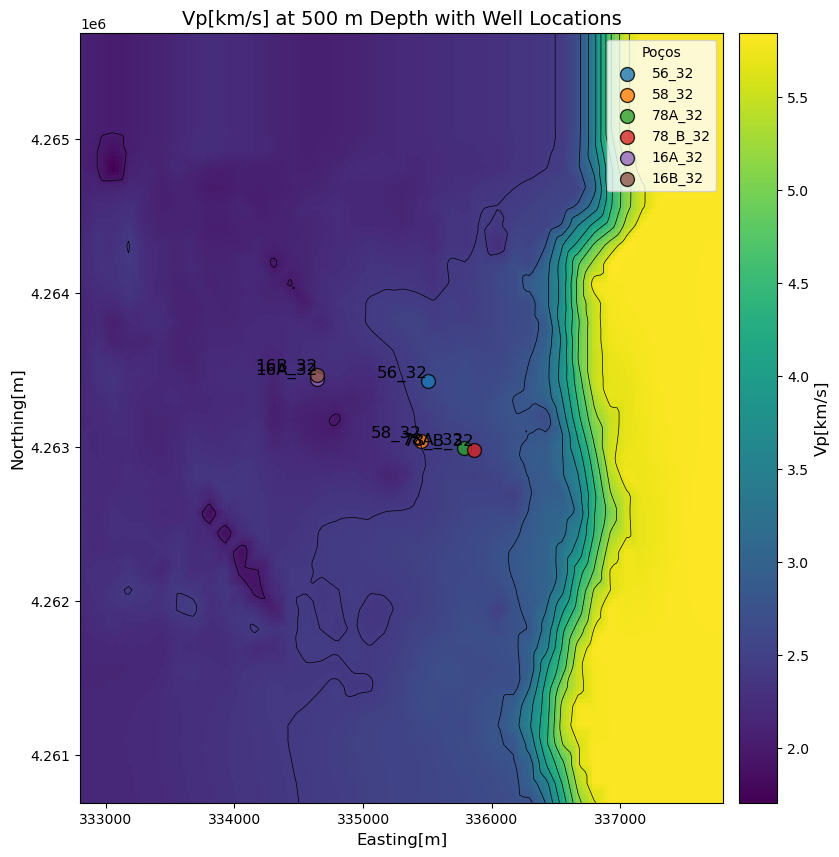

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_points_with_interpolation_and_wells(dataframe, property_col, z_value, well_df, font_size=10, circle_size=100, grid_res=200, cmap="viridis"):
    """
    Plota os pontos de dados da propriedade em 2D junto com as localizações dos poços no mesmo gráfico,
    com interpolação linear para uma visualização contínua da propriedade.

    Args:
    dataframe (pd.DataFrame): DataFrame com os dados da propriedade.
    property_col (str): Nome da coluna da propriedade para plotagem.
    z_value (float): Elevação z desejada.
    well_df (pd.DataFrame): DataFrame com os dados dos poços.
    font_size (int): Tamanho da fonte dos nomes dos poços.
    circle_size (int): Tamanho dos círculos representando os poços.
    grid_res (int): Resolução da grade para interpolação.
    cmap (str): Mapa de cores para a interpolação.
    """
    # Encontrar a elevação mais próxima
    if z_value not in dataframe['z[m]'].values:
        closest_z = dataframe['z[m]'].iloc[(dataframe['z[m]'] - z_value).abs().argmin()]
        print(f"A elevação {z_value} não existe. Usando a mais próxima: {closest_z}")
        z_value = closest_z

    # Filtrar o DataFrame para a elevação especificada
    df_filtered = dataframe[dataframe['z[m]'] == z_value]
    if df_filtered.empty:
        print("Nenhum dado encontrado na elevação especificada.")
        return

    # Preparar os dados
    x, y = df_filtered['Easting[m]'], df_filtered['Northing[m]']
    values = df_filtered[property_col]

    # Criar uma grade para interpolação
    grid_x, grid_y = np.linspace(x.min(), x.max(), grid_res), np.linspace(y.min(), y.max(), grid_res)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)
    grid_values = griddata((x, y), values, (grid_x, grid_y), method='linear')

    # Criar o gráfico
    fig, ax = plt.subplots(figsize=(10, 10))
    img = ax.imshow(grid_values, extent=(x.min(), x.max(), y.min(), y.max()), 
                    origin='lower', cmap=cmap, aspect='auto')
    
    # Adicionar contornos
    ax.contour(grid_x, grid_y, grid_values, levels=10, colors='black', linewidths=0.5)

    # Adicionar os poços ao gráfico
    colors = plt.cm.tab10(range(len(well_df)))
    for i, row in well_df.iterrows():
        ax.scatter(row["Easting_(x)_[m]"], row["Northing_(y)_[m]"], 
                   color=colors[i], s=circle_size, label=row["well"], alpha=0.8, edgecolor='black')
        ax.text(row["Easting_(x)_[m]"], row["Northing_(y)_[m]"], 
                row["well"], fontsize=font_size, ha='right', va='bottom')

    # Configurar eixos
    ax.set_xlabel("Easting[m]", fontsize=12)
    ax.set_ylabel("Northing[m]", fontsize=12)
    ax.set_title(f"{property_col} at {z_value} m Depth with Well Locations", fontsize=14)

    # Add color bar
    cbar = fig.colorbar(img, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label(property_col, fontsize=12)

    # Adicionar legenda
    ax.legend(title="Poços", fontsize=10, loc='upper right')

    plt.show()

# Exemplo de chamada da função
plot_points_with_interpolation_and_wells(dataframe=df, property_col="Vp[km/s]", z_value=500, well_df=local_well_df, font_size=12, circle_size=100)


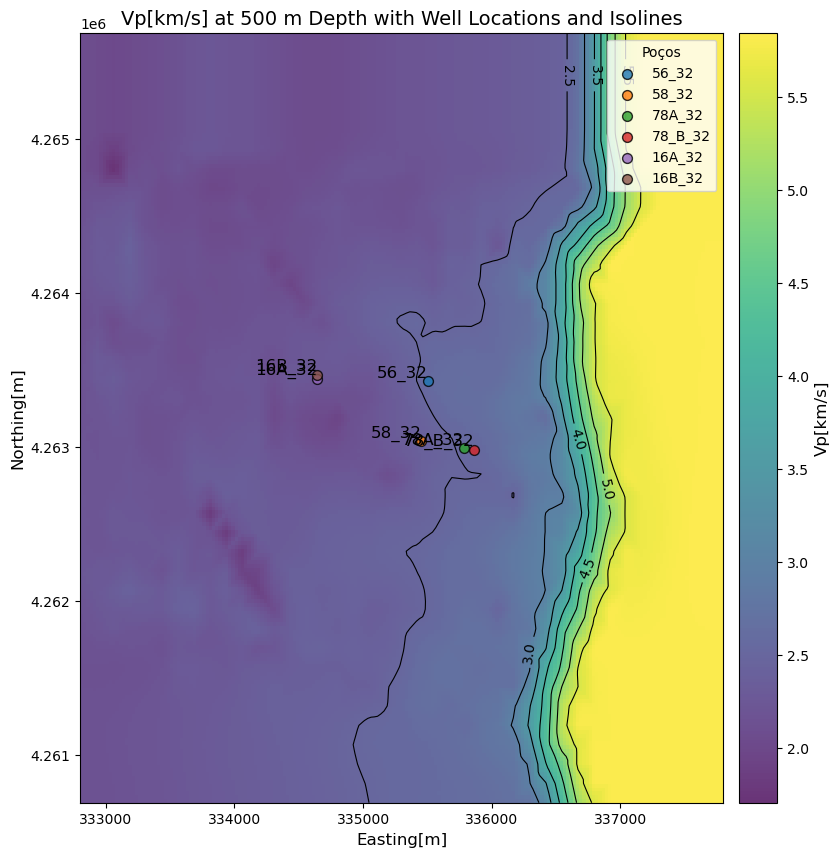

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_isolines_with_wells(dataframe, property_col, z_value, well_df, isoline_values, font_size=10, circle_size=100, grid_res=200, cmap="viridis"):
    """
    Plota isolinhas de valores da propriedade em 2D junto com as localizações dos poços no mesmo gráfico.

    Args:
    dataframe (pd.DataFrame): DataFrame com os dados da propriedade.
    property_col (str): Nome da coluna da propriedade para plotagem.
    z_value (float): Elevação z desejada.
    well_df (pd.DataFrame): DataFrame com os dados dos poços.
    isoline_values (list): Lista de valores para as isolinhas.
    font_size (int): Tamanho da fonte dos nomes dos poços.
    circle_size (int): Tamanho dos círculos representando os poços.
    grid_res (int): Resolução da grade para interpolação.
    cmap (str): Mapa de cores para a interpolação.
    """
    # Encontrar a elevação mais próxima
    if z_value not in dataframe['z[m]'].values:
        closest_z = dataframe['z[m]'].iloc[(dataframe['z[m]'] - z_value).abs().argmin()]
        print(f"A elevação {z_value} não existe. Usando a mais próxima: {closest_z}")
        z_value = closest_z

    # Filtrar o DataFrame para a elevação especificada
    df_filtered = dataframe[dataframe['z[m]'] == z_value]
    if df_filtered.empty:
        print("Nenhum dado encontrado na elevação especificada.")
        return

    # Preparar os dados
    x, y = df_filtered['Easting[m]'], df_filtered['Northing[m]']
    values = df_filtered[property_col]

    # Criar uma grade para interpolação
    grid_x, grid_y = np.linspace(x.min(), x.max(), grid_res), np.linspace(y.min(), y.max(), grid_res)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)
    grid_values = griddata((x, y), values, (grid_x, grid_y), method='linear')

    # Criar o gráfico
    fig, ax = plt.subplots(figsize=(10, 10))
    img = ax.imshow(grid_values, extent=(x.min(), x.max(), y.min(), y.max()), 
                    origin='lower', cmap=cmap, aspect='auto', alpha=0.8)
    
    # Adicionar isolinhas
    contour = ax.contour(grid_x, grid_y, grid_values, levels=isoline_values, colors='black', linewidths=0.8)
    ax.clabel(contour, fmt='%1.1f', inline=True, fontsize=10)

    # Adicionar os poços ao gráfico
    colors = plt.cm.tab10(range(len(well_df)))
    for i, row in well_df.iterrows():
        ax.scatter(row["Easting_(x)_[m]"], row["Northing_(y)_[m]"], 
                   color=colors[i], s=circle_size, label=row["well"], alpha=0.8, edgecolor='black')
        ax.text(row["Easting_(x)_[m]"], row["Northing_(y)_[m]"], 
                row["well"], fontsize=font_size, ha='right', va='bottom')

    # Configurar eixos
    ax.set_xlabel("Easting[m]", fontsize=12)
    ax.set_ylabel("Northing[m]", fontsize=12)
    ax.set_title(f"{property_col} at {z_value} m Depth with Well Locations and Isolines", fontsize=14)

    # Add color bar
    cbar = fig.colorbar(img, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label(property_col, fontsize=12)

    # Adicionar legenda
    ax.legend(title="Poços", fontsize=10, loc='upper right')

    plt.show()

# Exemplo de chamada da função
plot_isolines_with_wells(
    dataframe=df, 
    property_col="Vp[km/s]", 
    z_value=500, 
    well_df=local_well_df, 
    isoline_values=[2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5], 
    font_size=12, 
    circle_size=50
)


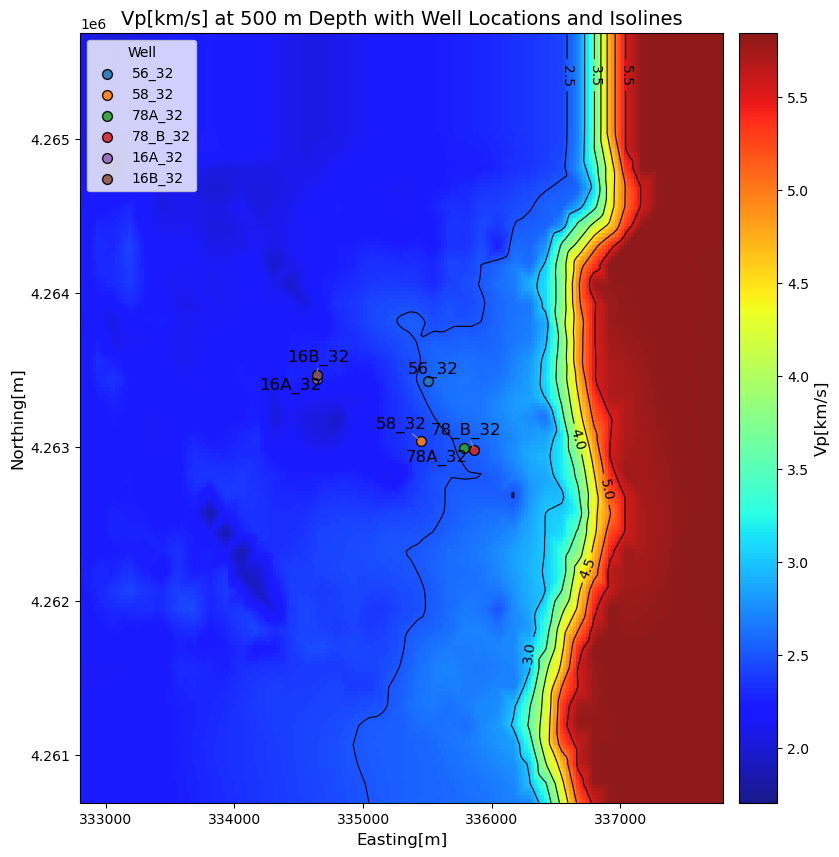

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from adjustText import adjust_text

def plot_isolines_with_wells(dataframe, property_col, z_value, well_df, isoline_values, font_size=10, circle_size=100, grid_res=200, cmap="jet"):
    """
    Plota isolinhas de valores da propriedade em 2D junto com as localizações dos poços no mesmo gráfico,
    evitando sobreposição de nomes dos poços.

    Args:
    dataframe (pd.DataFrame): DataFrame com os dados da propriedade.
    property_col (str): Nome da coluna da propriedade para plotagem.
    z_value (float): Elevação z desejada.
    well_df (pd.DataFrame): DataFrame com os dados dos poços.
    isoline_values (list): Lista de valores para as isolinhas.
    font_size (int): Tamanho da fonte dos nomes dos poços.
    circle_size (int): Tamanho dos círculos representando os poços.
    grid_res (int): Resolução da grade para interpolação.
    cmap (str): Mapa de cores para a interpolação.
    """
    # Encontrar a elevação mais próxima
    if z_value not in dataframe['z[m]'].values:
        closest_z = dataframe['z[m]'].iloc[(dataframe['z[m]'] - z_value).abs().argmin()]
        print(f"A elevação {z_value} não existe. Usando a mais próxima: {closest_z}")
        z_value = closest_z

    # Filtrar o DataFrame para a elevação especificada
    df_filtered = dataframe[dataframe['z[m]'] == z_value]
    if df_filtered.empty:
        print("Nenhum dado encontrado na elevação especificada.")
        return

    # Preparar os dados
    x, y = df_filtered['Easting[m]'], df_filtered['Northing[m]']
    values = df_filtered[property_col]

    # Criar uma grade para interpolação
    grid_x, grid_y = np.linspace(x.min(), x.max(), grid_res), np.linspace(y.min(), y.max(), grid_res)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)
    grid_values = griddata((x, y), values, (grid_x, grid_y), method='linear')

    # Criar o gráfico
    fig, ax = plt.subplots(figsize=(10, 10))
    img = ax.imshow(grid_values, extent=(x.min(), x.max(), y.min(), y.max()), 
                    origin='lower', cmap=cmap, aspect='auto', alpha=0.9)
    
    # Adicionar isolinhas
    contour = ax.contour(grid_x, grid_y, grid_values, levels=isoline_values, colors='black', linewidths=0.8)
    ax.clabel(contour, fmt='%1.1f', inline=True, fontsize=10)

    # Adicionar os poços ao gráfico
    colors = plt.cm.tab10(range(len(well_df)))
    texts = []  # Para armazenar os textos para ajuste
    for i, row in well_df.iterrows():
        ax.scatter(row["Easting_(x)_[m]"], row["Northing_(y)_[m]"], 
                   color=colors[i], s=circle_size, label=row["well"], alpha=0.9, edgecolor='black')
        # Adicionar texto para cada poço
        texts.append(
            ax.text(row["Easting_(x)_[m]"], row["Northing_(y)_[m]"], 
                    row["well"], fontsize=font_size, ha='right', va='bottom')
        )

    # Ajustar textos para evitar sobreposição
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

    # Configurar eixos
    ax.set_xlabel("Easting[m]", fontsize=12)
    ax.set_ylabel("Northing[m]", fontsize=12)
    ax.set_title(f"{property_col} at {z_value} m Depth with Well Locations and Isolines", fontsize=14)

    # Add color bar
    cbar = fig.colorbar(img, ax=ax, orientation='vertical', pad=0.02)
    cbar.set_label(property_col, fontsize=12)

    # Adicionar legenda
    ax.legend(title="Well", fontsize=10, loc='upper left')

    plt.show()

# Exemplo de chamada da função
plot_isolines_with_wells(
    dataframe=df, 
    property_col="Vp[km/s]", 
    z_value=500, 
    well_df=local_well_df, 
    isoline_values=[2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5], 
    font_size=12, 
    circle_size=50
)


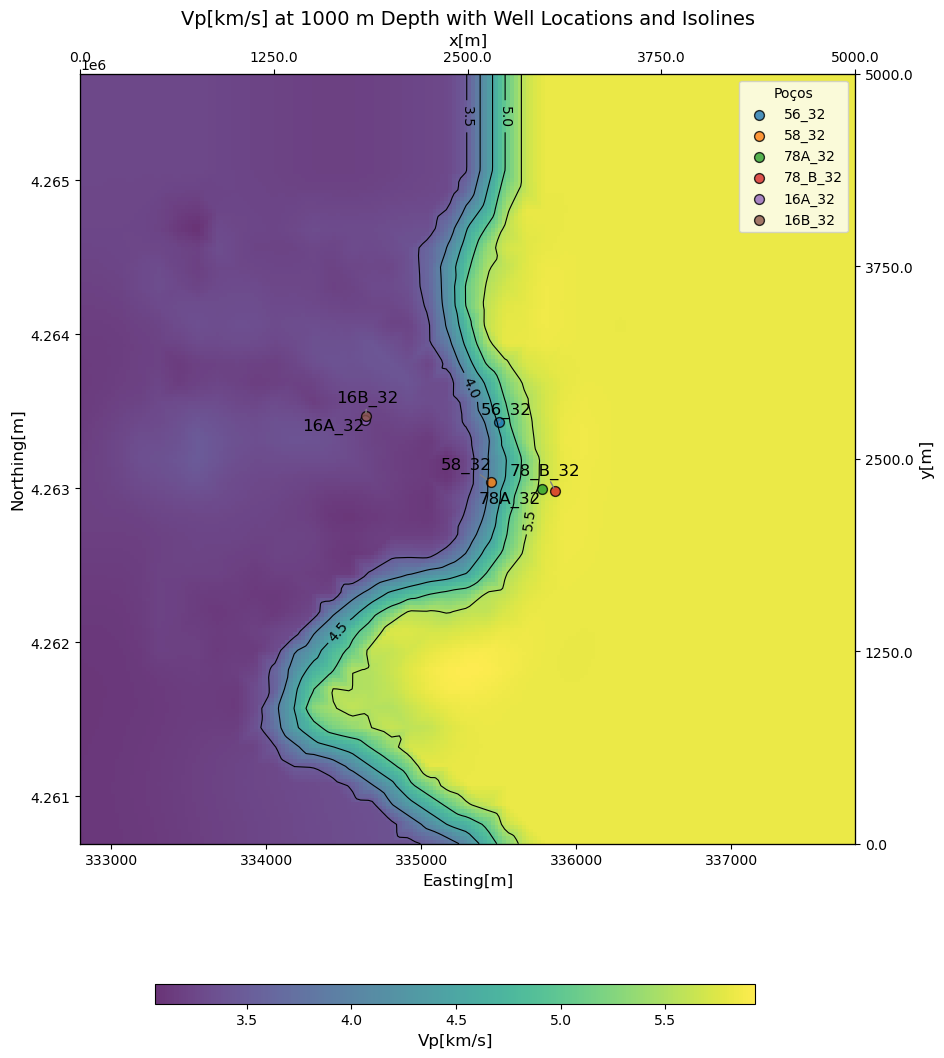

In [17]:
def plot_isolines_with_wells(dataframe, property_col, z_value, well_df, isoline_values, font_size=10, circle_size=100, grid_res=200, cmap="viridis"):
    """
    Plota isolinhas de valores da propriedade em 2D junto com as localizações dos poços no mesmo gráfico,
    com eixos superiores e direitos personalizados e legenda da propriedade na parte inferior.

    Args:
    dataframe (pd.DataFrame): DataFrame com os dados da propriedade.
    property_col (str): Nome da coluna da propriedade para plotagem.
    z_value (float): Elevação z desejada.
    well_df (pd.DataFrame): DataFrame com os dados dos poços.
    isoline_values (list): Lista de valores para as isolinhas.
    font_size (int): Tamanho da fonte dos nomes dos poços.
    circle_size (int): Tamanho dos círculos representando os poços.
    grid_res (int): Resolução da grade para interpolação.
    cmap (str): Mapa de cores para a interpolação.
    """
    # Encontrar a elevação mais próxima
    if z_value not in dataframe['z[m]'].values:
        closest_z = dataframe['z[m]'].iloc[(dataframe['z[m]'] - z_value).abs().argmin()]
        print(f"A elevação {z_value} não existe. Usando a mais próxima: {closest_z}")
        z_value = closest_z

    # Filtrar o DataFrame para a elevação especificada
    df_filtered = dataframe[dataframe['z[m]'] == z_value]
    if df_filtered.empty:
        print("Nenhum dado encontrado na elevação especificada.")
        return

    # Preparar os dados
    x, y = df_filtered['Easting[m]'], df_filtered['Northing[m]']
    values = df_filtered[property_col]
    x_alt = df_filtered['x[m]']  # Valores para o eixo superior
    y_alt = df_filtered['y[m]']  # Valores para o eixo direito

    # Criar uma grade para interpolação
    grid_x, grid_y = np.linspace(x.min(), x.max(), grid_res), np.linspace(y.min(), y.max(), grid_res)
    grid_x, grid_y = np.meshgrid(grid_x, grid_y)
    grid_values = griddata((x, y), values, (grid_x, grid_y), method='linear')

    # Criar o gráfico
    fig, ax = plt.subplots(figsize=(10, 10))
    img = ax.imshow(grid_values, extent=(x.min(), x.max(), y.min(), y.max()), 
                    origin='lower', cmap=cmap, aspect='auto', alpha=0.8)
    
    # Adicionar isolinhas
    contour = ax.contour(grid_x, grid_y, grid_values, levels=isoline_values, colors='black', linewidths=0.8)
    ax.clabel(contour, fmt='%1.1f', inline=True, fontsize=10)

    # Adicionar os poços ao gráfico
    colors = plt.cm.tab10(range(len(well_df)))
    texts = []  # Para armazenar os textos para ajuste
    for i, row in well_df.iterrows():
        ax.scatter(row["Easting_(x)_[m]"], row["Northing_(y)_[m]"], 
                   color=colors[i], s=circle_size, label=row["well"], alpha=0.8, edgecolor='black')
        # Adicionar texto para cada poço
        texts.append(
            ax.text(row["Easting_(x)_[m]"], row["Northing_(y)_[m]"], 
                    row["well"], fontsize=font_size, ha='right', va='bottom')
        )

    # Ajustar textos para evitar sobreposição
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

    # Configurar eixos principais
    ax.set_xlabel("Easting[m]", fontsize=12)
    ax.set_ylabel("Northing[m]", fontsize=12)
    ax.set_title(f"{property_col} at {z_value} m Depth with Well Locations and Isolines", fontsize=14)

    # Adicionar eixos superiores e direitos
    ax_top = ax.twiny()
    ax_right = ax.twinx()

    # Sincronizar limites dos eixos
    ax_top.set_xlim(ax.get_xlim())
    ax_right.set_ylim(ax.get_ylim())

    # Configurar rótulos e ticks dos eixos adicionais
    ax_top.set_xlabel("x[m]", fontsize=12)
    ax_top.set_xticks(np.linspace(x.min(), x.max(), 5))
    ax_top.set_xticklabels(np.round(np.linspace(x_alt.min(), x_alt.max(), 5), 2))

    ax_right.set_ylabel("y[m]", fontsize=12)
    ax_right.set_yticks(np.linspace(y.min(), y.max(), 5))
    ax_right.set_yticklabels(np.round(np.linspace(y_alt.min(), y_alt.max(), 5), 2))

    # Adicionar barra de cores na parte inferior
    cbar_ax = fig.add_axes([0.2, -0.05, 0.6, 0.02])  # [esquerda, inferior, largura, altura]
    cbar = fig.colorbar(img, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(property_col, fontsize=12)

    # Adicionar legenda
    ax.legend(title="Poços", fontsize=10, loc='upper right')

    plt.show()

# Exemplo de chamada da função
plot_isolines_with_wells(
    dataframe=df, 
    property_col="Vp[km/s]", 
    z_value=1000, 
    well_df=local_well_df, 
    isoline_values=[2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5], 
    font_size=12, 
    circle_size=50
)

## Função para salvar imagem

In [53]:
def save_or_show_plot(dataframe, property_col, z_value, well_df, isoline_values, font_size=10, circle_size=100, grid_res=200, cmap="viridis", save=False, file_path="plot.pdf", dpi=300):
    """
    Exibe ou salva o gráfico gerado pela função `plot_isolines_with_wells`.

    Args:
    save (bool): Indica se o gráfico deve ser salvo como PDF.
    file_path (str): Caminho para salvar o PDF.
    dpi (int): Resolução do gráfico ao salvar.
    """
    fig, ax = plot_isolines_with_wells(
        dataframe, property_col, z_value, well_df, isoline_values, font_size, circle_size, grid_res, cmap
    )
    if save:
        fig.savefig(file_path, format='pdf', dpi=dpi, bbox_inches='tight')
        print(f"Gráfico salvo em: {file_path}")
    else:
        plt.show()

In [ ]:
# Exemplo de chamada para salvar ou exibir o gráfico
save_or_show_plot(
    dataframe=df,
    property_col="Vp[km/s]",
    z_value=500,
    well_df=local_well_df,
    isoline_values=[2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5],
    font_size=12,
    circle_size=50,
    save=True,  # Define se o gráfico será salvo
    file_path="mapa_wells.pdf",
    dpi=300
)

## Trajectories Wells

Reference:  https://gdr.openei.org/submissions/1292; https://gdr.openei.org/submissions/1323 ; https://gdr.openei.org/submissions/1531; https://gdr.openei.org/submissions/1006

In [2]:
import pandas as pd

# Atualize o caminho para o arquivo correto
file_path = "/home/marcus/Documentos/qualificacao_mestrado/dados_forge/well_16_A_(78)_32/diretional_well/directional_16A_32_X_Y_TVD_MD_p1.txt"

# Definir os nomes das colunas
columns = ["Easting[m]", "Northing[m]", "TVD[m]", "MD[m]"]

try:
    # Ler o arquivo e carregar no dataframe
    traje_16A_78 = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns)
    # Exibir o dataframe diretamente no console
    print(traje_16A_78)
except FileNotFoundError:
    print(f"O arquivo não foi encontrado no caminho especificado: {file_path}")


      Easting[m]  Northing[m]   TVD[m]     MD[m]
0    334641.1891  4263443.693     0.00     0.000
1    334641.1373  4263443.766    30.48    30.480
2    334641.0184  4263443.916    60.96    60.960
3    334640.8691  4263444.065    91.44    91.440
4    334640.7410  4263444.181   121.92   121.920
..           ...          ...      ...       ...
106  335732.5987  4263143.596  2567.08  3230.880
107  335760.4574  4263137.875  2578.03  3261.360
108  335788.5081  4263132.834  2588.84  3291.840
109  335816.5436  4263128.201  2599.86  3322.320
110  335832.0336  4263125.817  2605.81  3339.084

[111 rows x 4 columns]


/tmp/ipykernel_7372/191097937.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  traje_16A_78 = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns)


In [3]:
import pandas as pd

# Atualize o caminho para o arquivo correto
file_path = "/home/marcus/Documentos/qualificacao_mestrado/dados_forge/well_16_B_(78)_32/trajectory/directional_16B_32_X_Y_TVD_MD_p1.txt"

# Definir os nomes das colunas
columns = ["Easting[m]", "Northing[m]", "TVD[m]", "MD[m]"]

try:
    # Ler o arquivo e carregar no dataframe
    traje_16B_78 = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns)
    # Exibir o dataframe diretamente no console
    print(traje_16B_78)
except FileNotFoundError:
    print(f"O arquivo não foi encontrado no caminho especificado: {file_path}")


     Easting[m]   Northing[m]   TVD[m]    MD[m]
0    334642.054  4.263471e+06     0.00     0.00
1    334642.054  4.263471e+06     7.62     7.62
2    334642.054  4.263471e+06    15.24    15.24
3    334642.054  4.263471e+06    22.86    22.86
4    334642.054  4.263471e+06    30.48    30.48
..          ...           ...      ...      ...
423  335840.527  4.263143e+06  2517.64  3242.74
424  335857.596  4.263139e+06  2526.15  3262.27
425  335883.199  4.263133e+06  2538.44  3291.23
426  335900.573  4.263129e+06  2546.70  3310.74
427  335923.433  4.263124e+06  2557.69  3336.65

[428 rows x 4 columns]


/tmp/ipykernel_7372/2821120208.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  traje_16B_78 = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns)


In [4]:
import pandas as pd

# Atualize o caminho para o arquivo correto
file_path = "/home/marcus/Documentos/qualificacao_mestrado/dados_forge/well_58_32/Directional_Survey_well_58_32/directional_58_32_X_Y_TVD_MD.txt"

# Definir os nomes das colunas
columns = ["Easting[m]", "Northing[m]", "TVD[m]", "MD[m]"]

try:
    # Ler o arquivo e carregar no dataframe
    traje_58_32 = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns)
    # Exibir o dataframe diretamente no console
    print(traje_58_32)
except FileNotFoundError:
    print(f"O arquivo não foi encontrado no caminho especificado: {file_path}")


    Easting[m]  Northing[m]   TVD[m]    MD[m]
0    335450.98   4263037.90     0.00     0.00
1    335451.07   4263038.11    84.73    84.73
2    335451.04   4263038.11   177.39   177.39
3    335450.95   4263038.20   264.57   264.57
4    335450.74   4263039.36   361.19   361.19
5    335450.40   4263040.86   448.33   448.36
6    335449.73   4263042.65   545.26   545.29
7    335449.91   4263045.34   651.57   651.66
8    335451.28   4263046.65   730.82   730.91
9    335452.56   4263047.44   843.56   843.69
10   335451.89   4263048.69   940.19   940.31
11   335451.99   4263048.81  1030.10  1030.22
12   335451.89   4263047.17  1126.69  1126.85
13   335448.39   4263045.40  1211.64  1211.88
14   335440.16   4263043.20  1307.87  1308.51
15   335430.92   4263040.70  1391.44  1392.63
16   335429.64   4263040.55  1401.74  1402.99
17   335427.21   4263040.73  1421.07  1422.50
18   335424.55   4263040.92  1442.86  1444.45
19   335423.40   4263040.95  1452.55  1454.20
20   335422.18   4263040.98  1462.

/tmp/ipykernel_7372/2758267249.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  traje_58_32 = pd.read_csv(file_path, delim_whitespace=True, header=None, names=columns)


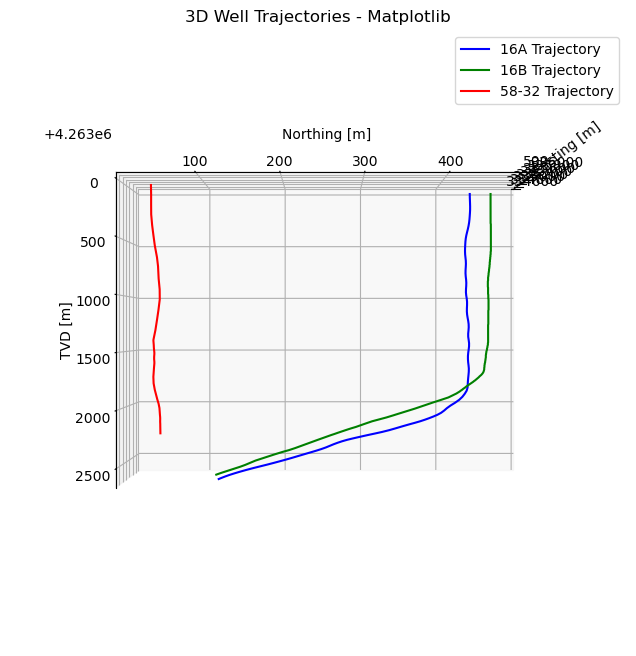

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_trajectories_matplotlib(traj_16A, traj_16B, traje_58_32, angle_elev=30, angle_azim=45):
    """
    Plota trajetórias em 3D usando matplotlib com TVD contando para baixo.

    Args:
    traj_16A (pd.DataFrame): Dataframe com dados de 16A.
    traj_16B (pd.DataFrame): Dataframe com dados de 16B.
    angle_elev (int): Ângulo de elevação da câmera.
    angle_azim (int): Ângulo azimutal da câmera.
    """
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plotar os dados de 16A
    ax.plot(traj_16A["Easting[m]"], traj_16A["Northing[m]"], traj_16A["TVD[m]"],
            label="16A Trajectory", color="blue")
    
    # Plotar os dados de 16B
    ax.plot(traj_16B["Easting[m]"], traj_16B["Northing[m]"], traj_16B["TVD[m]"],
            label="16B Trajectory", color="green")
    # Plotar os dados de 16B
    ax.plot(traje_58_32["Easting[m]"], traje_58_32["Northing[m]"], traje_58_32["TVD[m]"],
            label="58-32 Trajectory", color="red")

    # Configurar rótulos
    ax.set_xlabel("Easting [m]")
    ax.set_ylabel("Northing [m]")
    ax.set_zlabel("TVD [m]")
    ax.set_title("3D Well Trajectories - Matplotlib")

    # Inverter o eixo Z para que conte para baixo
    ax.invert_zaxis()

    # Ajustar ângulos de visualização
    ax.view_init(elev=angle_elev, azim=angle_azim)

    # Legenda
    ax.legend()

    plt.show()

# Exemplo de uso:
plot_trajectories_matplotlib(traje_16A_78, traje_16B_78,traje_58_32, angle_elev=0, angle_azim=0)

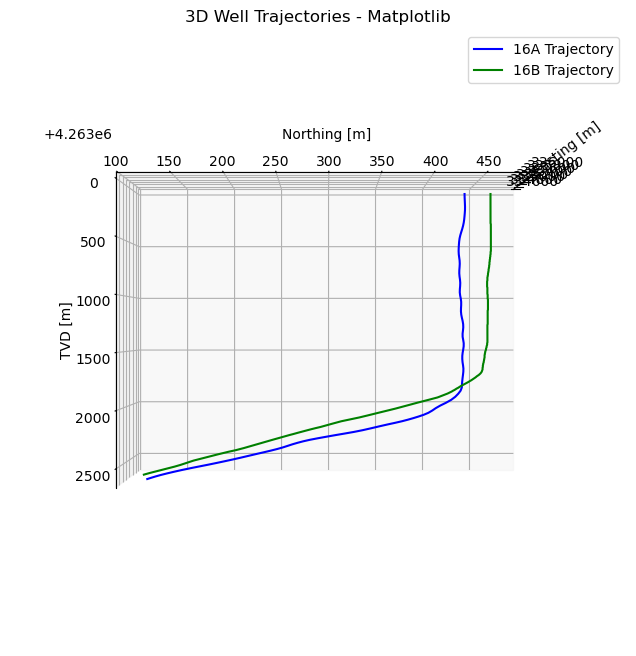

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_trajectories_matplotlib(traj_16A, traj_16B, angle_elev=30, angle_azim=45):
    """
    Plota trajetórias em 3D usando matplotlib com TVD contando para baixo.

    Args:
    traj_16A (pd.DataFrame): Dataframe com dados de 16A.
    traj_16B (pd.DataFrame): Dataframe com dados de 16B.
    angle_elev (int): Ângulo de elevação da câmera.
    angle_azim (int): Ângulo azimutal da câmera.
    """
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plotar os dados de 16A
    ax.plot(traj_16A["Easting[m]"], traj_16A["Northing[m]"], traj_16A["TVD[m]"],
            label="16A Trajectory", color="blue")
    
    # Plotar os dados de 16B
    ax.plot(traj_16B["Easting[m]"], traj_16B["Northing[m]"], traj_16B["TVD[m]"],
            label="16B Trajectory", color="green")

    # Configurar rótulos
    ax.set_xlabel("Easting [m]")
    ax.set_ylabel("Northing [m]")
    ax.set_zlabel("TVD [m]")
    ax.set_title("3D Well Trajectories - Matplotlib")

    # Inverter o eixo Z para que conte para baixo
    ax.invert_zaxis()

    # Ajustar ângulos de visualização
    ax.view_init(elev=angle_elev, azim=angle_azim)

    # Legenda
    ax.legend()

    plt.show()

# Exemplo de uso:
plot_trajectories_matplotlib(traje_16A_78, traje_16B_78, angle_elev=0, angle_azim=0)


In [11]:
import pyvista as pv

def plot_trajectories_pyvista(traj_16A, traj_16B,traj_58_32):
    """
    Plota trajetórias em 3D usando PyVista.

    Args:
    traj_16A (pd.DataFrame): Dataframe com dados de 16A.
    traj_16B (pd.DataFrame): Dataframe com dados de 16B.
    """
    # Criar o plotter
    plotter = pv.Plotter()

    # Adicionar os dados de 16A
    trajectory_16A = pv.lines_from_points(
        traj_16A[["Easting[m]", "Northing[m]", "TVD[m]"]].values
    )
    plotter.add_mesh(trajectory_16A, color="blue", line_width=3, label="16A Trajectory")

    # Adicionar os dados de 16B
    trajectory_16B = pv.lines_from_points(
        traj_16B[["Easting[m]", "Northing[m]", "TVD[m]"]].values
    )
    plotter.add_mesh(trajectory_16B, color="green", line_width=3, label="16B Trajectory")

     # Adicionar os dados de 16B
    trajectory_58_32 = pv.lines_from_points(
        traje_58_32[["Easting[m]", "Northing[m]", "TVD[m]"]].values
    )
    plotter.add_mesh(trajectory_58_32, color="red", line_width=3, label="58-32 Trajectory")


    # Configurações
    plotter.add_axes(labels_off=False)
    plotter.add_legend()
    plotter.show()

# Exemplo de uso:
plot_trajectories_pyvista(traje_16A_78, traje_16B_78,traje_58_32)


Widget(value='<iframe src="http://localhost:44045/index.html?ui=P_0x75a4ab94b010_4&reconnect=auto" class="pyvi…

In [6]:
import pyvista as pv
import numpy as np

def plot_trajectories_with_image(traj_16A, traj_16B, traj_58_32, image_path, z_level):
    """
    Plota trajetórias em 3D usando PyVista e adiciona uma imagem como plano de fundo em um valor específico de Z.

    Args:
    traj_16A (pd.DataFrame): Dataframe com dados de 16A.
    traj_16B (pd.DataFrame): Dataframe com dados de 16B.
    traj_58_32 (pd.DataFrame): Dataframe com dados de 58-32.
    image_path (str): Caminho da imagem a ser carregada.
    z_level (float): Nível de Z no qual a imagem será inserida.
    """
    # Criar o plotter
    plotter = pv.Plotter()

    # Adicionar os dados de 16A
    trajectory_16A = pv.lines_from_points(
        traj_16A[["Easting[m]", "Northing[m]", "TVD[m]"]].values
    )
    plotter.add_mesh(trajectory_16A, color="blue", line_width=3, label="16A Trajectory")

    # Adicionar os dados de 16B
    trajectory_16B = pv.lines_from_points(
        traj_16B[["Easting[m]", "Northing[m]", "TVD[m]"]].values
    )
    plotter.add_mesh(trajectory_16B, color="green", line_width=3, label="16B Trajectory")

    # Adicionar os dados de 58-32
    trajectory_58_32 = pv.lines_from_points(
        traj_58_32[["Easting[m]", "Northing[m]", "TVD[m]"]].values
    )
    plotter.add_mesh(trajectory_58_32, color="red", line_width=3, label="58-32 Trajectory")

    # Definir os limites do plano com base nas coordenadas mínimas e máximas das trajetórias
    x_min, x_max = min(traj_16A["Easting[m]"].min(), traj_16B["Easting[m]"].min(), traj_58_32["Easting[m]"].min()), \
                   max(traj_16A["Easting[m]"].max(), traj_16B["Easting[m]"].max(), traj_58_32["Easting[m]"].max())

    y_min, y_max = min(traj_16A["Northing[m]"].min(), traj_16B["Northing[m]"].min(), traj_58_32["Northing[m]"].min()), \
                   max(traj_16A["Northing[m]"].max(), traj_16B["Northing[m]"].max(), traj_58_32["Northing[m]"].max())

    # Criar um plano para a imagem
    plane = pv.Plane(center=((x_min + x_max) / 2, (y_min + y_max) / 2, z_level),
                     direction=(0, 0, 1),
                     i_size=(x_max - x_min),
                     j_size=(y_max - y_min))

    # Carregar a imagem e aplicar como textura ao plano
    texture = pv.Texture(image_path)
    plotter.add_mesh(plane, texture=texture)

    # Configurações
    plotter.add_axes(labels_off=False)
    plotter.add_legend()
    plotter.show()

# Exemplo de uso:
image_path = "/home/marcus/Imagens/Capturas de tela/potencial_superficie.png"  # Atualize com o caminho correto da imagem
z_level = 0  # Defina o valor de Z desejado para a projeção da imagem
plot_trajectories_with_image(traje_16A_78, traje_16B_78, traje_58_32, image_path, z_level)


Widget(value='<iframe src="http://localhost:44045/index.html?ui=P_0x75a4af55e800_1&reconnect=auto" class="pyvi…

In [8]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_trajectories_with_image(traj_16A, traj_16B, traj_58_32, image_path, z_level, x_bounds, y_bounds):
    """
    Plota trajetórias em 3D usando PyVista e adiciona uma imagem georreferenciada como fundo.

    Args:
    traj_16A (pd.DataFrame): Dataframe com dados de 16A.
    traj_16B (pd.DataFrame): Dataframe com dados de 16B.
    traj_58_32 (pd.DataFrame): Dataframe com dados de 58-32.
    image_path (str): Caminho da imagem a ser carregada.
    z_level (float): Nível de Z no qual a imagem será inserida.
    x_bounds (tuple): Limites em X (min_x, max_x) da imagem no espaço 3D.
    y_bounds (tuple): Limites em Y (min_y, max_y) da imagem no espaço 3D.
    """
    # Criar o plotter
    plotter = pv.Plotter()

    # Adicionar os dados de 16A
    trajectory_16A = pv.lines_from_points(
        traj_16A[["Easting[m]", "Northing[m]", "TVD[m]"]].values
    )
    plotter.add_mesh(trajectory_16A, color="blue", line_width=3, label="16A Trajectory")

    # Adicionar os dados de 16B
    trajectory_16B = pv.lines_from_points(
        traj_16B[["Easting[m]", "Northing[m]", "TVD[m]"]].values
    )
    plotter.add_mesh(trajectory_16B, color="green", line_width=3, label="16B Trajectory")

    # Adicionar os dados de 58-32
    trajectory_58_32 = pv.lines_from_points(
        traj_58_32[["Easting[m]", "Northing[m]", "TVD[m]"]].values
    )
    plotter.add_mesh(trajectory_58_32, color="red", line_width=3, label="58-32 Trajectory")

    # Criar um plano para a imagem
    x_min, x_max = x_bounds
    y_min, y_max = y_bounds

    plane = pv.Plane(center=((x_min + x_max) / 2, (y_min + y_max) / 2, z_level),
                     direction=(0, 0, 1),
                     i_size=(x_max - x_min),
                     j_size=(y_max - y_min))

    # Carregar a imagem e aplicar como textura ao plano
    texture = pv.read_texture(image_path)
    plotter.add_mesh(plane, texture=texture)

    # Configurações
    plotter.add_axes(labels_off=False)
    plotter.add_legend()
    plotter.show()

# Defina os limites reais da sua imagem no espaço 3D
x_bounds = ( 332699,336939)  # Exemplo de limites reais da imagem em coordenadas UTM
y_bounds = (4261165, 4264798)

# Caminho da imagem
image_path = "/home/marcus/Imagens/Capturas de tela/potencial_superficie.png"
z_level = 0  # Defina o nível de profundidade desejado

# Chamando a função com limites ajustados
plot_trajectories_with_image(traje_16A_78, traje_16B_78, traje_58_32, image_path, z_level, x_bounds, y_bounds)


Widget(value='<iframe src="http://localhost:44045/index.html?ui=P_0x75a4ab96e9e0_3&reconnect=auto" class="pyvi…

## Load trajectory data wells with correction elevation

Elevations references:
58 -32 = 5557.5 ft = 1693.926 m
16A-78 = 5435.5 ft = 1656.7404 m
16B-78 = 5442.65 ft = 1658,91972 m

reference: data .las from wells elevation reference is kellybushing from each wells

In [ ]:
elevationsreference = {
    "well": ["58_32", "16A_32", "16B_32"],
    "Elevation_well[m]": [1693.92,1656.74,1658.91]}


In [10]:
# Definindo as elevações de cada poço
elevations = {
    "traje_58_32": 1693.92,
    "traje_16A_78": 1656.74,
    "traje_16B_78": 1658.91
}

# Lista dos DataFrames
dataframes = {
    "traje_58_32": traje_58_32,
    "traje_16A_78": traje_16A_78,
    "traje_16B_78": traje_16B_78
}

# Manipulando os DataFrames
for name, df in dataframes.items():
    # Remover a coluna se já existir
    if "Elevation_well[m]" in df.columns:
        df.drop(columns=["Elevation_well[m]"], inplace=True)
    
    # Criar e inserir a nova coluna na posição correta (entre "Northing[m]" e "TVD[m]")
    df.insert(2, "Elevation_well[m]", (elevations[name] - df["TVD[m]"]).round(2))

# Exibir os DataFrames modificados
print("Trajetória 58-32:\n", traje_58_32.head())
print("\nTrajetória 16A-78:\n", traje_16A_78.head())
print("\nTrajetória 16B-78:\n", traje_16B_78.head())

Trajetória 58-32:
    Easting[m]  Northing[m]  Elevation_well[m]  TVD[m]   MD[m]
0   335450.98   4263037.90            1693.92    0.00    0.00
1   335451.07   4263038.11            1609.19   84.73   84.73
2   335451.04   4263038.11            1516.53  177.39  177.39
3   335450.95   4263038.20            1429.35  264.57  264.57
4   335450.74   4263039.36            1332.73  361.19  361.19

Trajetória 16A-78:
     Easting[m]  Northing[m]  Elevation_well[m]  TVD[m]   MD[m]
0  334641.1891  4263443.693            1656.74    0.00    0.00
1  334641.1373  4263443.766            1626.26   30.48   30.48
2  334641.0184  4263443.916            1595.78   60.96   60.96
3  334640.8691  4263444.065            1565.30   91.44   91.44
4  334640.7410  4263444.181            1534.82  121.92  121.92

Trajetória 16B-78:
    Easting[m]   Northing[m]  Elevation_well[m]  TVD[m]  MD[m]
0  334642.054  4.263471e+06            1658.91    0.00   0.00
1  334642.054  4.263471e+06            1651.29    7.62   7.62
2  

In [14]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_trajectories_with_image(traj_16A, traj_16B, traj_58_32, image_path, z_level, x_bounds, y_bounds):
    """
    Plota trajetórias em 3D usando PyVista e adiciona uma imagem georreferenciada como fundo.

    Args:
    traj_16A (pd.DataFrame): Dataframe com dados de 16A.
    traj_16B (pd.DataFrame): Dataframe com dados de 16B.
    traj_58_32 (pd.DataFrame): Dataframe com dados de 58-32.
    image_path (str): Caminho da imagem a ser carregada.
    z_level (float): Nível de Z no qual a imagem será inserida.
    x_bounds (tuple): Limites em X (min_x, max_x) da imagem no espaço 3D.
    y_bounds (tuple): Limites em Y (min_y, max_y) da imagem no espaço 3D.
    """
    # Criar o plotter
    plotter = pv.Plotter()

    # Adicionar os dados de 16A
    trajectory_16A = pv.lines_from_points(
        traj_16A[["Easting[m]", "Northing[m]", "Elevation_well[m]"]].values
    )
    plotter.add_mesh(trajectory_16A, color="blue", line_width=3, label="16A Trajectory")

    # Adicionar os dados de 16B
    trajectory_16B = pv.lines_from_points(
        traj_16B[["Easting[m]", "Northing[m]", "Elevation_well[m]"]].values
    )
    plotter.add_mesh(trajectory_16B, color="green", line_width=3, label="16B Trajectory")

    # Adicionar os dados de 58-32
    trajectory_58_32 = pv.lines_from_points(
        traj_58_32[["Easting[m]", "Northing[m]", "Elevation_well[m]"]].values
    )
    plotter.add_mesh(trajectory_58_32, color="red", line_width=3, label="58-32 Trajectory")

    # Criar um plano para a imagem
    x_min, x_max = x_bounds
    y_min, y_max = y_bounds

    plane = pv.Plane(center=((x_min + x_max) / 2, (y_min + y_max) / 2, z_level),
                     direction=(0, 0, 1),
                     i_size=(x_max - x_min),
                     j_size=(y_max - y_min))

    # Carregar a imagem e aplicar como textura ao plano
    texture = pv.read_texture(image_path)
    plotter.add_mesh(plane, texture=texture)

    # Configurações
    plotter.add_axes(labels_off=False)
    plotter.add_legend()
    plotter.show()

# Defina os limites reais da sua imagem no espaço 3D
x_bounds = ( 332699,336939)  # Exemplo de limites reais da imagem em coordenadas UTM
y_bounds = (4261165, 4264798)

# Caminho da imagem
image_path = "/home/marcus/Imagens/Capturas de tela/potencial_superficie.png"
z_level = 1693  # Defina o nível de profundidade desejado

# Chamando a função com limites ajustados
plot_trajectories_with_image(traje_16A_78, traje_16B_78, traje_58_32, image_path, z_level, x_bounds, y_bounds)


Widget(value='<iframe src="http://localhost:44045/index.html?ui=P_0x75a4acd3c460_7&reconnect=auto" class="pyvi…

In [16]:
# Definir o diretório de saída
output_directory = "/home/marcus/Área de Trabalho/data_mayara/trajectory/"

# Definir os nomes dos arquivos para cada DataFrame
file_names = {
    "traje_58_32": "direct_58_32_X_Y_Z_TVD_MD.txt",
    "traje_16A_78": "direct_16A_78_X_Y_Z_TVD_MD.txt",
    "traje_16B_78": "direct_16B_78_X_Y_Z_TVD_MD.txt"
}

# Salvar os arquivos no formato .txt sem a linha de cabeçalho
for name, df in dataframes.items():
    file_path = output_directory + file_names[name]
    df.to_csv(file_path, sep=" ", index=False, header=True)

print("Arquivos salvos com sucesso na pasta:", output_directory)


Arquivos salvos com sucesso na pasta: /home/marcus/Área de Trabalho/data_mayara/trajectory/
